In [1]:
# !pip install datasets
# !pip install transformers[torch]
# !pip install accelerate -U

In [12]:
import torch
import torch.nn.functional as F
from src.utils import *
from src.models.models import Model_Phrase_Concatenation, Model_Phrase_Extraction, Model_concat_nopooling
from src.models.baseline import Baseline
from datasets import concatenate_datasets
from sklearn.utils.class_weight import compute_class_weight
from transformers import DefaultDataCollator, AutoTokenizer, TrainingArguments, Trainer

In [13]:
RANDOM_SEED = 42
set_seeds(RANDOM_SEED)

print(torch.__version__)
print(torch.cuda.is_available())

2.1.0+cu121
True


In [14]:
url = "https://drive.google.com/uc?export=download&id=1wVNU2XvvhqjaGXZM-JLJwOt97gt4g9j2"
dataset_name = "MELD_train_efr.json"

df_manager = DataframeManager(url, dataset_name)

df = df_manager.produce_df()
df

Current work directory: c:\Users\marco\OneDrive\Immagini\Documenti\GitHub\ediref


,episode,emotions,utterances,triggers,emotions_id
0,utterance_0,"[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0, 0, 0, 1, 0]","[4, 4, 4, 4, 3]"
1,utterance_1,"[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0, 0, 0, 0, 0, 1, 0]","[4, 4, 4, 4, 3, 4, 4]"
2,utterance_2,"[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]","[4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 1]"
3,utterance_3,"[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 1, 4, 3]"
4,utterance_4,"[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0, 0, 1, 0]","[3, 0, 3, 1]"
...,...,...,...,...,...
3995,utterance_3995,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[4, 6, 4, 4, 3, 2, 4, 2, 3, 4, 4, 2]"
3996,utterance_3996,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[4, 6, 4, 4, 3, 2, 4, 2, 3, 4, 4, 2, 2, 4]"
3997,utterance_3997,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[4, 6, 4, 4, 3, 2, 4, 2, 3, 4, 4, 2, 2, 4, 4]"
3998,utterance_3998,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[4, 6, 4, 4, 3, 2, 4, 2, 3, 4, 4, 2, 2, 4, 4, 3]"


In [15]:
train_df, val_df, test_df = df_manager.split_df(RANDOM_SEED)
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(3200, 5)
(400, 5)
(400, 5)


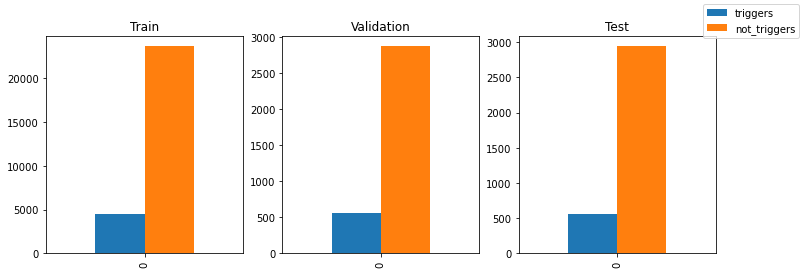

In [5]:
df_manager.plot_triggers_distribution(train_df, val_df, test_df)

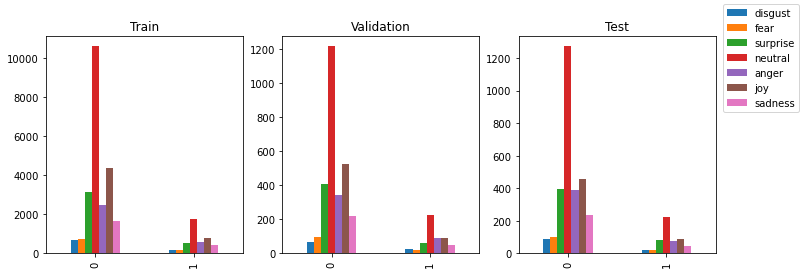

In [6]:
df_manager.plot_emotion_distribution(train_df, val_df, test_df)

In [16]:
model_card = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_card)

model_dir = "./model_dir/"+model_card+"/"
data_collator = DefaultDataCollator()

In [26]:
train_data_tokenized, val_data_tokenized, test_data_tokenized = df_manager.produce_dataset(tokenizer, RANDOM_SEED)

In [27]:
print(len(train_data_tokenized))
print(len(val_data_tokenized))
print(len(test_data_tokenized))

28062
3437
3501


Models

In [18]:
seeds = [49, 666, 51, 77, 111]

X = train_data_tokenized['dialogue_index']
Y = train_data_tokenized.select_columns(['triggers', 'emotions_id'])
seed_table = {'majority': {}, 'uniform': {}}

id2emotion = df_manager.get_id2emotion()
random_clf = Baseline("uniform", X, Y)
majority_clf = Baseline("most_frequent", X, Y)
for seed in seeds:
    seed_table["uniform"][seed] = random_clf.score()
    seed_table["majority"][seed] = majority_clf.score()

In [19]:
seed_table

{'majority': {49: {'accuracy_emotions': 0.4392060437602452,
   'accuracy_triggers': 0.8414938350794668,
   'f1scores_emotions': 0.0872,
   'f1scores_triggers': 0.1306,
   'u_avg_f1': 0.1089},
  666: {'accuracy_emotions': 0.4392060437602452,
   'accuracy_triggers': 0.8414938350794668,
   'f1scores_emotions': 0.0872,
   'f1scores_triggers': 0.1306,
   'u_avg_f1': 0.1089},
  51: {'accuracy_emotions': 0.4392060437602452,
   'accuracy_triggers': 0.8414938350794668,
   'f1scores_emotions': 0.0872,
   'f1scores_triggers': 0.1306,
   'u_avg_f1': 0.1089},
  77: {'accuracy_emotions': 0.4392060437602452,
   'accuracy_triggers': 0.8414938350794668,
   'f1scores_emotions': 0.0872,
   'f1scores_triggers': 0.1306,
   'u_avg_f1': 0.1089},
  111: {'accuracy_emotions': 0.4392060437602452,
   'accuracy_triggers': 0.8414938350794668,
   'f1scores_emotions': 0.0872,
   'f1scores_triggers': 0.1306,
   'u_avg_f1': 0.1089}},
 'uniform': {49: {'accuracy_emotions': 0.1433611289288005,
   'accuracy_triggers': 0.

In [13]:
model_B = Model_Phrase_Extraction(len(df_manager.unique_emotions), tokenizer.sep_token_id)
# model_B = concat_nopooling(df_manager)
def try_model_Concatenation(batch_start, batch_end, model):
    outputs_text = model(utterance_ids=train_data_tokenized[batch_start:batch_end]['utterance_ids'],
            utterance_mask=train_data_tokenized[batch_start:batch_end]['utterance_mask'],
            dialogue_ids=train_data_tokenized[batch_start:batch_end]['dialogue_ids'],
            dialogue_mask=train_data_tokenized[batch_start:batch_end]['dialogue_mask'],
            utterance_index=train_data_tokenized[batch_start:batch_end]['utterance_index'],
            dialogue_index=train_data_tokenized[batch_start:batch_end]['dialogue_index'],
            token_type_ids=None)
    return outputs_text

# outputs_text = try_model_Concatenation(2, 6, model_B)

# print(outputs_text['emotion_logits'].shape)
# print(outputs_text['trigger_logits'].shape)

In [7]:
def init_pos_weight(data, labels_column, class_weights=True, factor=1):
    y = data[labels_column].numpy()
    if class_weights:
        return torch.tensor(compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)).to("cuda")
    else:
        return torch.tensor(compute_class_weight(class_weight=None, classes=np.unique(y), y=y)).to("cuda")

In [39]:
class MultiLabelTrainer(Trainer):
    def __init__(self, pos_weight=None, **kwargs):
        self.emotions_pos_weight, self.triggers_pos_weight = pos_weight
        super().__init__(**kwargs)

    def compute_loss(self, model, inputs, return_outputs=False):
        emotions_true = inputs["emotions_id_one_hot_encoding"].to("cuda")
        triggers_true = inputs["triggers"].unsqueeze(1).float().to("cuda")

        result = model(**inputs)
        
        emotion_logits = result['emotion_logits'].to("cuda")
        trigger_logits = result['trigger_logits'].to("cuda")
        
        loss_fct_emotions = torch.nn.CrossEntropyLoss(weight=self.emotions_pos_weight).to("cuda")        
        loss_fct_triggers = torch.nn.BCEWithLogitsLoss(pos_weight=self.triggers_pos_weight[1]).to("cuda")
        
        # loss_fct_emotions = torch.nn.CrossEntropyLoss().to("cuda")        
        # loss_fct_triggers = torch.nn.BCEWithLogitsLoss().to("cuda")

        # preds = F.sigmoid(trigger_logits)
        loss_emotions = loss_fct_emotions(emotion_logits, emotions_true.float())
        loss_triggers = loss_fct_triggers(trigger_logits, triggers_true)

        # l1 = torch.nn.CrossEntropyLoss()
        # l2 = torch.nn.BCEWithLogitsLoss()
        # e = l1(emotion_logits, emotions_true.float())
        # t = l2(trigger_logits, triggers_true)

        loss_emotions_wt = 0.5
        loss_triggers_wt = 0.5

        loss = loss_emotions_wt*loss_emotions + loss_triggers_wt*loss_triggers
        return (loss, {'emotion_logits': emotion_logits, 'trigger_logits': trigger_logits}) if return_outputs else loss

def get_trainer(model, train, val, model_dir, class_weights=True, batch_size=1, epochs=20):
    training_args = TrainingArguments(
        output_dir=model_dir,
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        evaluation_strategy="no",
        save_strategy="epoch",
        save_total_limit=1,
        lr_scheduler_type="cosine",
        report_to='none',
        label_names=["emotions_id", "triggers", "dialogue_index"],
    )

    full_dataset = concatenate_datasets([train_data_tokenized, val_data_tokenized, test_data_tokenized])
    pos_weight = (init_pos_weight(full_dataset, df_manager.column_emotions_id, class_weights), init_pos_weight(full_dataset, df_manager.column_triggers, class_weights))

    trainer = MultiLabelTrainer(
        pos_weight=pos_weight,
        model=model,
        args=training_args,
        train_dataset=train,
        eval_dataset=val,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=lambda pred: compute_metrics(pred, len(df_manager.emotion2id.keys()))
    )

    return trainer

In [10]:
num_emotions = len(df_manager.unique_emotions)
models_to_train_abl = {
    "bert_concat": Model_Phrase_Concatenation(num_emotions, tokenizer.sep_token_id),
    "bert_concat_nopooling": Model_concat_nopooling(num_emotions, tokenizer.sep_token_id),
    "bert_extraction": Model_Phrase_Extraction(num_emotions, tokenizer.sep_token_id)
}

In [9]:
def train_extr_model(seed, model_card="bert-base-uncased", freeze=False):
    set_seeds(seed)
    base_model = Model_Phrase_Extraction(len(df_manager.unique_emotions), tokenizer.sep_token_id, model_card, freeze)
    model_path = model_dir+"bert_extraction_freeze_"+str(seed) if freeze else model_dir+"bert_extraction_"+str(seed)

    trainer = get_trainer(base_model, train_data_tokenized, val_data_tokenized, model_path, class_weights=True, batch_size=4, epochs=5)

    print(f'Training EXTRACTION MODEL with seed {seed}:')

    trainer.train()
    save_name = "/bert_extraction_freeze_"+str(seed)+".pth" if freeze else "/bert_extraction_"+str(seed)+".pth"
    torch.save(base_model.state_dict(), model_path+save_name)

In [32]:
def train_nopooling_model(seed, model_card="bert-base-uncased", freeze=False):
    set_seeds(seed)
    base_model = Model_concat_nopooling(len(df_manager.unique_emotions), tokenizer.sep_token_id, model_card, freeze)
    model_path = model_dir+"bert_concat_nopooling_freeze_"+str(seed) if freeze else model_dir+"bert_concat_nopooling_"+str(seed)

    trainer = get_trainer(base_model, train_data_tokenized, val_data_tokenized, model_path, class_weights=True, batch_size=4, epochs=5)

    print(f'Training NOPOOLING MODEL with seed {seed}:')

    trainer.train()
    save_name = "/bert_concat_nopooling_freeze_"+str(seed)+".pth" if freeze else "/bert_concat_nopooling_"+str(seed)+".pth"
    torch.save(base_model.state_dict(), model_path+save_name)

In [33]:
def train_concat_model(seed, model_card="bert-base-uncased", freeze=False):
    set_seeds(seed)
    base_model = Model_Phrase_Concatenation(len(df_manager.unique_emotions), tokenizer.sep_token_id, model_card, freeze)
    model_path = model_dir+"bert_concat_freeze_"+str(seed) if freeze else model_dir+"bert_concat_"+str(seed)

    trainer = get_trainer(base_model, train_data_tokenized, val_data_tokenized, model_path, class_weights=True, batch_size=4, epochs=5)

    print(f'Training NOPOOLING MODEL with seed {seed}:')

    trainer.train()
    save_name = "/bert_concat_freeze_"+str(seed)+".pth" if freeze else "/bert_concat_"+str(seed)+".pth"
    torch.save(base_model.state_dict(), model_path+save_name)

In [ ]:
seeds = [666, 51, 77, 111]

<h3>TRAIN NOPOOLING MODELS</h3>

In [34]:
train_nopooling_model(666)

c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Training NOPOOLING MODEL with seed 666:


  0%|          | 0/35080 [00:00<?, ?it/s]

Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'loss': 1.5435, 'grad_norm': 21.049175262451172, 'learning_rate': 1.9989976531650042e-05, 'epoch': 0.07}
{'loss': 1.4689, 'grad_norm': 6.833110809326172, 'learning_rate': 1.9959926220583713e-05, 'epoch': 0.14}
{'loss': 1.3946, 'grad_norm': 4.627593040466309, 'learning_rate': 1.9909909308469398e-05, 'epoch': 0.21}
{'loss': 1.3846, 'grad_norm': 21.170927047729492, 'learning_rate': 1.9840026063894193e-05, 'epoch': 0.29}
{'loss': 1.3771, 'grad_norm': 7.251065254211426, 'learning_rate': 1.9750416581356147e-05, 'epoch': 0.36}
{'loss': 1.3497, 'grad_norm': 4.823225021362305, 'learning_rate': 1.9641260500417672e-05, 'epoch': 0.43}
{'loss': 1.3686, 'grad_norm': 7.498763561248779, 'learning_rate': 1.9512776645583266e-05, 'epoch': 0.5}
{'loss': 1.2957, 'grad_norm': 32.99750518798828, 'learning_rate': 1.9365222587623407e-05, 'epoch': 0.57}
{'loss': 1.312, 'grad_norm': 9.95146656036377, 'learning_rate': 1.9198894127224075e-05, 'epoch': 0.64}
{'loss': 1.2999, 'grad_norm': 13.090883255004883, 'learn

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 1.2227733828617335, 'eval_accuracy_emotions': 0.5988, 'eval_accuracy_triggers': 0.7835, 'eval_u_avg_f1': 0.4794, 'eval_u_f1scores_emotions': 0.4664, 'eval_u_f1scores_triggers': 0.4924, 'eval_d_f1scores_emotions': 0.6072, 'eval_d_f1scores_triggers': 0.7535, 'eval_runtime': 643.9111, 'eval_samples_per_second': 5.338, 'eval_steps_per_second': 1.336, 'epoch': 1.0}
{'loss': 1.1868, 'grad_norm': 14.961058616638184, 'learning_rate': 1.7827877610796515e-05, 'epoch': 1.07}
{'loss': 1.1607, 'grad_norm': 26.275514602661133, 'learning_rate': 1.7541478823146328e-05, 'epoch': 1.14}
{'loss': 1.134, 'grad_norm': 12.552483558654785, 'learning_rate': 1.7239961680637002e-05, 'epoch': 1.21}
{'loss': 1.1519, 'grad_norm': 15.743618965148926, 'learning_rate': 1.6923930632775517e-05, 'epoch': 1.28}
{'loss': 1.0236, 'grad_norm': 6.738943576812744, 'learning_rate': 1.6594019225003043e-05, 'epoch': 1.35}
{'loss': 1.0659, 'grad_norm': 13.012080192565918, 'learning_rate': 1.62508888286304e-05, 'epoch

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 0.9757741806734822, 'eval_accuracy_emotions': 0.7562, 'eval_accuracy_triggers': 0.8312, 'eval_u_avg_f1': 0.5954, 'eval_u_f1scores_emotions': 0.708, 'eval_u_f1scores_triggers': 0.4829, 'eval_d_f1scores_emotions': 0.749, 'eval_d_f1scores_triggers': 0.7913, 'eval_runtime': 641.3934, 'eval_samples_per_second': 5.359, 'eval_steps_per_second': 1.341, 'epoch': 2.0}
{'loss': 0.806, 'grad_norm': 15.867147445678711, 'learning_rate': 1.2688968189084494e-05, 'epoch': 2.07}
{'loss': 0.8413, 'grad_norm': 12.18295955657959, 'learning_rate': 1.225513357792187e-05, 'epoch': 2.14}
{'loss': 0.8394, 'grad_norm': 30.812488555908203, 'learning_rate': 1.1816778114750594e-05, 'epoch': 2.21}
{'loss': 0.8243, 'grad_norm': 29.343320846557617, 'learning_rate': 1.13747805679929e-05, 'epoch': 2.28}
{'loss': 0.846, 'grad_norm': 11.432252883911133, 'learning_rate': 1.0930027007332924e-05, 'epoch': 2.35}
{'loss': 0.813, 'grad_norm': 139.07350158691406, 'learning_rate': 1.0483409027418426e-05, 'epoch': 2.

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 0.9132623331896397, 'eval_accuracy_emotions': 0.8184, 'eval_accuracy_triggers': 0.8231, 'eval_u_avg_f1': 0.644, 'eval_u_f1scores_emotions': 0.7933, 'eval_u_f1scores_triggers': 0.4946, 'eval_d_f1scores_emotions': 0.8106, 'eval_d_f1scores_triggers': 0.7853, 'eval_runtime': 642.186, 'eval_samples_per_second': 5.352, 'eval_steps_per_second': 1.339, 'epoch': 3.0}
{'loss': 0.7222, 'grad_norm': 28.396488189697266, 'learning_rate': 6.527489286891458e-06, 'epoch': 3.06}
{'loss': 0.7665, 'grad_norm': 15.410980224609375, 'learning_rate': 6.111198874944846e-06, 'epoch': 3.14}
{'loss': 0.7007, 'grad_norm': 27.196365356445312, 'learning_rate': 5.702704317997491e-06, 'epoch': 3.21}
{'loss': 0.7075, 'grad_norm': 16.874601364135742, 'learning_rate': 5.302824522501931e-06, 'epoch': 3.28}
{'loss': 0.6879, 'grad_norm': 67.58008575439453, 'learning_rate': 4.912361124952949e-06, 'epoch': 3.35}
{'loss': 0.7371, 'grad_norm': 12.793712615966797, 'learning_rate': 4.532096884851978e-06, 'epoch': 3.

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 0.9700639476682201, 'eval_accuracy_emotions': 0.8589, 'eval_accuracy_triggers': 0.8024, 'eval_u_avg_f1': 0.6948, 'eval_u_f1scores_emotions': 0.8404, 'eval_u_f1scores_triggers': 0.5492, 'eval_d_f1scores_emotions': 0.8533, 'eval_d_f1scores_triggers': 0.7693, 'eval_runtime': 644.7453, 'eval_samples_per_second': 5.331, 'eval_steps_per_second': 1.334, 'epoch': 4.0}
{'loss': 0.7127, 'grad_norm': 20.369461059570312, 'learning_rate': 1.6865479389478545e-06, 'epoch': 4.06}
{'loss': 0.6415, 'grad_norm': 67.45567321777344, 'learning_rate': 1.4461099843816684e-06, 'epoch': 4.13}
{'loss': 0.6668, 'grad_norm': 48.73006057739258, 'learning_rate': 1.2228199589835998e-06, 'epoch': 4.2}
{'loss': 0.6743, 'grad_norm': 45.05727005004883, 'learning_rate': 1.0171254908541373e-06, 'epoch': 4.28}
{'loss': 0.7584, 'grad_norm': 7.581765174865723, 'learning_rate': 8.294389343914899e-07, 'epoch': 4.35}
{'loss': 0.6768, 'grad_norm': 18.29268455505371, 'learning_rate': 6.601365436473439e-07, 'epoch': 4

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 1.029063081651802, 'eval_accuracy_emotions': 0.8665, 'eval_accuracy_triggers': 0.8065, 'eval_u_avg_f1': 0.6996, 'eval_u_f1scores_emotions': 0.8452, 'eval_u_f1scores_triggers': 0.5541, 'eval_d_f1scores_emotions': 0.8589, 'eval_d_f1scores_triggers': 0.7742, 'eval_runtime': 641.9631, 'eval_samples_per_second': 5.354, 'eval_steps_per_second': 1.34, 'epoch': 5.0}
{'train_runtime': 12727.6777, 'train_samples_per_second': 11.024, 'train_steps_per_second': 2.756, 'train_loss': 0.9176728591135997, 'epoch': 5.0}


In [35]:
train_nopooling_model(51)

c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Training NOPOOLING MODEL with seed 51:


  0%|          | 0/35080 [00:00<?, ?it/s]

Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'loss': 1.5752, 'grad_norm': 17.321617126464844, 'learning_rate': 1.9989976531650042e-05, 'epoch': 0.07}
{'loss': 1.4971, 'grad_norm': 6.476842880249023, 'learning_rate': 1.9959926220583713e-05, 'epoch': 0.14}
{'loss': 1.4055, 'grad_norm': 4.3822126388549805, 'learning_rate': 1.9909909308469398e-05, 'epoch': 0.21}
{'loss': 1.3876, 'grad_norm': 20.830284118652344, 'learning_rate': 1.9840026063894193e-05, 'epoch': 0.29}
{'loss': 1.3987, 'grad_norm': 6.851800441741943, 'learning_rate': 1.9750416581356147e-05, 'epoch': 0.36}
{'loss': 1.3711, 'grad_norm': 4.564669609069824, 'learning_rate': 1.9641260500417672e-05, 'epoch': 0.43}
{'loss': 1.3812, 'grad_norm': 6.331668376922607, 'learning_rate': 1.9512776645583266e-05, 'epoch': 0.5}
{'loss': 1.3197, 'grad_norm': 22.884294509887695, 'learning_rate': 1.9365222587623407e-05, 'epoch': 0.57}
{'loss': 1.3296, 'grad_norm': 7.685431957244873, 'learning_rate': 1.9198894127224075e-05, 'epoch': 0.64}
{'loss': 1.3401, 'grad_norm': 8.3024263381958, 'lear

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 1.2426002322762475, 'eval_accuracy_emotions': 0.5374, 'eval_accuracy_triggers': 0.7873, 'eval_u_avg_f1': 0.447, 'eval_u_f1scores_emotions': 0.3911, 'eval_u_f1scores_triggers': 0.5028, 'eval_d_f1scores_emotions': 0.5395, 'eval_d_f1scores_triggers': 0.7569, 'eval_runtime': 641.1818, 'eval_samples_per_second': 5.36, 'eval_steps_per_second': 1.341, 'epoch': 1.0}
{'loss': 1.2426, 'grad_norm': 9.49957275390625, 'learning_rate': 1.7827877610796515e-05, 'epoch': 1.07}
{'loss': 1.231, 'grad_norm': 10.063718795776367, 'learning_rate': 1.7541478823146328e-05, 'epoch': 1.14}
{'loss': 1.1986, 'grad_norm': 19.602205276489258, 'learning_rate': 1.7239961680637002e-05, 'epoch': 1.21}
{'loss': 1.1947, 'grad_norm': 8.824554443359375, 'learning_rate': 1.6923930632775517e-05, 'epoch': 1.28}
{'loss': 1.0763, 'grad_norm': 10.201091766357422, 'learning_rate': 1.6594019225003043e-05, 'epoch': 1.35}
{'loss': 1.1083, 'grad_norm': 15.650068283081055, 'learning_rate': 1.62508888286304e-05, 'epoch': 1

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 1.0443094371663264, 'eval_accuracy_emotions': 0.7219, 'eval_accuracy_triggers': 0.8199, 'eval_u_avg_f1': 0.5751, 'eval_u_f1scores_emotions': 0.6711, 'eval_u_f1scores_triggers': 0.4791, 'eval_d_f1scores_emotions': 0.7164, 'eval_d_f1scores_triggers': 0.7803, 'eval_runtime': 643.2842, 'eval_samples_per_second': 5.343, 'eval_steps_per_second': 1.337, 'epoch': 2.0}
{'loss': 0.859, 'grad_norm': 21.250499725341797, 'learning_rate': 1.2688968189084494e-05, 'epoch': 2.07}
{'loss': 0.8951, 'grad_norm': 13.3119478225708, 'learning_rate': 1.225513357792187e-05, 'epoch': 2.14}
{'loss': 0.8869, 'grad_norm': 26.680709838867188, 'learning_rate': 1.1816778114750594e-05, 'epoch': 2.21}
{'loss': 0.8412, 'grad_norm': 16.560510635375977, 'learning_rate': 1.13747805679929e-05, 'epoch': 2.28}
{'loss': 0.8969, 'grad_norm': 9.181397438049316, 'learning_rate': 1.0930027007332924e-05, 'epoch': 2.35}
{'loss': 0.8439, 'grad_norm': 56.86676788330078, 'learning_rate': 1.0483409027418426e-05, 'epoch': 2

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 0.9327491590407251, 'eval_accuracy_emotions': 0.794, 'eval_accuracy_triggers': 0.8295, 'eval_u_avg_f1': 0.6217, 'eval_u_f1scores_emotions': 0.7643, 'eval_u_f1scores_triggers': 0.4791, 'eval_d_f1scores_emotions': 0.7856, 'eval_d_f1scores_triggers': 0.789, 'eval_runtime': 643.9679, 'eval_samples_per_second': 5.337, 'eval_steps_per_second': 1.335, 'epoch': 3.0}
{'loss': 0.7338, 'grad_norm': 78.05684661865234, 'learning_rate': 6.527489286891458e-06, 'epoch': 3.06}
{'loss': 0.7693, 'grad_norm': 18.218338012695312, 'learning_rate': 6.111198874944846e-06, 'epoch': 3.14}
{'loss': 0.7319, 'grad_norm': 54.29219055175781, 'learning_rate': 5.702704317997491e-06, 'epoch': 3.21}
{'loss': 0.7367, 'grad_norm': 11.57997989654541, 'learning_rate': 5.302824522501931e-06, 'epoch': 3.28}
{'loss': 0.7236, 'grad_norm': 159.38169860839844, 'learning_rate': 4.912361124952949e-06, 'epoch': 3.35}
{'loss': 0.7261, 'grad_norm': 10.150269508361816, 'learning_rate': 4.532096884851978e-06, 'epoch': 3.42

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 0.9455097333284872, 'eval_accuracy_emotions': 0.8542, 'eval_accuracy_triggers': 0.803, 'eval_u_avg_f1': 0.6797, 'eval_u_f1scores_emotions': 0.8296, 'eval_u_f1scores_triggers': 0.5298, 'eval_d_f1scores_emotions': 0.8505, 'eval_d_f1scores_triggers': 0.7686, 'eval_runtime': 640.5838, 'eval_samples_per_second': 5.365, 'eval_steps_per_second': 1.343, 'epoch': 4.0}
{'loss': 0.729, 'grad_norm': 17.11652946472168, 'learning_rate': 1.6865479389478545e-06, 'epoch': 4.06}
{'loss': 0.6428, 'grad_norm': 116.95448303222656, 'learning_rate': 1.4461099843816684e-06, 'epoch': 4.13}
{'loss': 0.6326, 'grad_norm': 26.291603088378906, 'learning_rate': 1.2228199589835998e-06, 'epoch': 4.2}
{'loss': 0.6885, 'grad_norm': 31.287939071655273, 'learning_rate': 1.0171254908541373e-06, 'epoch': 4.28}
{'loss': 0.7504, 'grad_norm': 6.978219985961914, 'learning_rate': 8.294389343914899e-07, 'epoch': 4.35}
{'loss': 0.667, 'grad_norm': 37.051353454589844, 'learning_rate': 6.601365436473439e-07, 'epoch': 4

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 0.9969433511771446, 'eval_accuracy_emotions': 0.8554, 'eval_accuracy_triggers': 0.8033, 'eval_u_avg_f1': 0.6834, 'eval_u_f1scores_emotions': 0.8329, 'eval_u_f1scores_triggers': 0.5339, 'eval_d_f1scores_emotions': 0.8488, 'eval_d_f1scores_triggers': 0.7707, 'eval_runtime': 640.6516, 'eval_samples_per_second': 5.365, 'eval_steps_per_second': 1.342, 'epoch': 5.0}
{'train_runtime': 12721.0733, 'train_samples_per_second': 11.03, 'train_steps_per_second': 2.758, 'train_loss': 0.9455921316636193, 'epoch': 5.0}


In [36]:
train_nopooling_model(77)

c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Training NOPOOLING MODEL with seed 77:


  0%|          | 0/35080 [00:00<?, ?it/s]

Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'loss': 1.5696, 'grad_norm': 23.076730728149414, 'learning_rate': 1.9989976531650042e-05, 'epoch': 0.07}
{'loss': 1.4859, 'grad_norm': 6.132292747497559, 'learning_rate': 1.9959926220583713e-05, 'epoch': 0.14}
{'loss': 1.4003, 'grad_norm': 5.022042274475098, 'learning_rate': 1.9909909308469398e-05, 'epoch': 0.21}
{'loss': 1.495, 'grad_norm': 21.29616355895996, 'learning_rate': 1.9840026063894193e-05, 'epoch': 0.29}
{'loss': 1.4605, 'grad_norm': 4.247101306915283, 'learning_rate': 1.9750416581356147e-05, 'epoch': 0.36}
{'loss': 1.4602, 'grad_norm': 5.142590522766113, 'learning_rate': 1.9641260500417672e-05, 'epoch': 0.43}
{'loss': 1.4605, 'grad_norm': 11.402143478393555, 'learning_rate': 1.9512776645583266e-05, 'epoch': 0.5}
{'loss': 1.3851, 'grad_norm': 23.576309204101562, 'learning_rate': 1.9365222587623407e-05, 'epoch': 0.57}
{'loss': 1.4079, 'grad_norm': 7.862736225128174, 'learning_rate': 1.9198894127224075e-05, 'epoch': 0.64}
{'loss': 1.4748, 'grad_norm': 6.277125358581543, 'lear

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 1.3683534543700018, 'eval_accuracy_emotions': 0.4737, 'eval_accuracy_triggers': 0.835, 'eval_u_avg_f1': 0.3402, 'eval_u_f1scores_emotions': 0.2254, 'eval_u_f1scores_triggers': 0.455, 'eval_d_f1scores_emotions': 0.4762, 'eval_d_f1scores_triggers': 0.7938, 'eval_runtime': 644.3647, 'eval_samples_per_second': 5.334, 'eval_steps_per_second': 1.335, 'epoch': 1.0}
{'loss': 1.4366, 'grad_norm': 7.953241348266602, 'learning_rate': 1.7827877610796515e-05, 'epoch': 1.07}
{'loss': 1.4182, 'grad_norm': 2.8942368030548096, 'learning_rate': 1.7541478823146328e-05, 'epoch': 1.14}
{'loss': 1.3651, 'grad_norm': 22.310771942138672, 'learning_rate': 1.7239961680637002e-05, 'epoch': 1.21}
{'loss': 1.3956, 'grad_norm': 8.185952186584473, 'learning_rate': 1.6923930632775517e-05, 'epoch': 1.28}
{'loss': 1.2956, 'grad_norm': 6.737220287322998, 'learning_rate': 1.6594019225003043e-05, 'epoch': 1.35}
{'loss': 1.3122, 'grad_norm': 11.679232597351074, 'learning_rate': 1.62508888286304e-05, 'epoch': 

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 1.3347824936499322, 'eval_accuracy_emotions': 0.5426, 'eval_accuracy_triggers': 0.835, 'eval_u_avg_f1': 0.3944, 'eval_u_f1scores_emotions': 0.3337, 'eval_u_f1scores_triggers': 0.455, 'eval_d_f1scores_emotions': 0.5399, 'eval_d_f1scores_triggers': 0.7938, 'eval_runtime': 641.2436, 'eval_samples_per_second': 5.36, 'eval_steps_per_second': 1.341, 'epoch': 2.0}
{'loss': 1.2468, 'grad_norm': 7.841518402099609, 'learning_rate': 1.2688968189084494e-05, 'epoch': 2.07}
{'loss': 1.2238, 'grad_norm': 12.256824493408203, 'learning_rate': 1.225513357792187e-05, 'epoch': 2.14}
{'loss': 1.2458, 'grad_norm': 123.78314208984375, 'learning_rate': 1.1816778114750594e-05, 'epoch': 2.21}
{'loss': 1.1989, 'grad_norm': 18.218656539916992, 'learning_rate': 1.13747805679929e-05, 'epoch': 2.28}
{'loss': 1.2299, 'grad_norm': 13.572213172912598, 'learning_rate': 1.0930027007332924e-05, 'epoch': 2.35}
{'loss': 1.1966, 'grad_norm': 25.44835090637207, 'learning_rate': 1.0483409027418426e-05, 'epoch': 2

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 1.1384856922376478, 'eval_accuracy_emotions': 0.6351, 'eval_accuracy_triggers': 0.8152, 'eval_u_avg_f1': 0.5105, 'eval_u_f1scores_emotions': 0.5227, 'eval_u_f1scores_triggers': 0.4982, 'eval_d_f1scores_emotions': 0.6383, 'eval_d_f1scores_triggers': 0.7783, 'eval_runtime': 638.8207, 'eval_samples_per_second': 5.38, 'eval_steps_per_second': 1.346, 'epoch': 3.0}
{'loss': 1.023, 'grad_norm': 29.307058334350586, 'learning_rate': 6.527489286891458e-06, 'epoch': 3.06}
{'loss': 1.0448, 'grad_norm': 21.722152709960938, 'learning_rate': 6.111198874944846e-06, 'epoch': 3.14}
{'loss': 1.0289, 'grad_norm': 116.28885650634766, 'learning_rate': 5.702704317997491e-06, 'epoch': 3.21}
{'loss': 1.0044, 'grad_norm': 35.56200408935547, 'learning_rate': 5.302824522501931e-06, 'epoch': 3.28}
{'loss': 1.0465, 'grad_norm': 49.4491081237793, 'learning_rate': 4.912361124952949e-06, 'epoch': 3.35}
{'loss': 0.9734, 'grad_norm': 9.203435897827148, 'learning_rate': 4.532096884851978e-06, 'epoch': 3.42}

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 1.0735636953327445, 'eval_accuracy_emotions': 0.7201, 'eval_accuracy_triggers': 0.8182, 'eval_u_avg_f1': 0.576, 'eval_u_f1scores_emotions': 0.6523, 'eval_u_f1scores_triggers': 0.4998, 'eval_d_f1scores_emotions': 0.7182, 'eval_d_f1scores_triggers': 0.7804, 'eval_runtime': 642.6165, 'eval_samples_per_second': 5.348, 'eval_steps_per_second': 1.338, 'epoch': 4.0}
{'loss': 0.8902, 'grad_norm': 24.29273223876953, 'learning_rate': 1.6865479389478545e-06, 'epoch': 4.06}
{'loss': 0.8616, 'grad_norm': 126.81484985351562, 'learning_rate': 1.4461099843816684e-06, 'epoch': 4.13}
{'loss': 0.8406, 'grad_norm': 28.251375198364258, 'learning_rate': 1.2228199589835998e-06, 'epoch': 4.2}
{'loss': 0.8946, 'grad_norm': 26.608909606933594, 'learning_rate': 1.0171254908541373e-06, 'epoch': 4.28}
{'loss': 0.9266, 'grad_norm': 10.111003875732422, 'learning_rate': 8.294389343914899e-07, 'epoch': 4.35}
{'loss': 0.8931, 'grad_norm': 21.485729217529297, 'learning_rate': 6.601365436473439e-07, 'epoch'

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 1.0535296302580814, 'eval_accuracy_emotions': 0.7338, 'eval_accuracy_triggers': 0.81, 'eval_u_avg_f1': 0.5881, 'eval_u_f1scores_emotions': 0.6666, 'eval_u_f1scores_triggers': 0.5096, 'eval_d_f1scores_emotions': 0.7309, 'eval_d_f1scores_triggers': 0.7742, 'eval_runtime': 660.8594, 'eval_samples_per_second': 5.201, 'eval_steps_per_second': 1.301, 'epoch': 5.0}
{'train_runtime': 12884.9477, 'train_samples_per_second': 10.889, 'train_steps_per_second': 2.723, 'train_loss': 1.1629944667576928, 'epoch': 5.0}


In [41]:
train_nopooling_model(111)

c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Training NOPOOLING MODEL with seed 111:


  0%|          | 0/35080 [00:00<?, ?it/s]

Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'loss': 1.5684, 'grad_norm': 25.229841232299805, 'learning_rate': 1.9989976531650042e-05, 'epoch': 0.07}
{'loss': 1.4908, 'grad_norm': 6.358502388000488, 'learning_rate': 1.9959926220583713e-05, 'epoch': 0.14}
{'loss': 1.3963, 'grad_norm': 4.444218158721924, 'learning_rate': 1.9909909308469398e-05, 'epoch': 0.21}
{'loss': 1.3867, 'grad_norm': 20.7325496673584, 'learning_rate': 1.9840026063894193e-05, 'epoch': 0.29}
{'loss': 1.3797, 'grad_norm': 6.934471607208252, 'learning_rate': 1.9750416581356147e-05, 'epoch': 0.36}
{'loss': 1.3522, 'grad_norm': 4.501838207244873, 'learning_rate': 1.9641260500417672e-05, 'epoch': 0.43}
{'loss': 1.3715, 'grad_norm': 7.1990251541137695, 'learning_rate': 1.9512776645583266e-05, 'epoch': 0.5}
{'loss': 1.3062, 'grad_norm': 23.94189453125, 'learning_rate': 1.9365222587623407e-05, 'epoch': 0.57}
{'loss': 1.3147, 'grad_norm': 8.062478065490723, 'learning_rate': 1.9198894127224075e-05, 'epoch': 0.64}
{'loss': 1.3091, 'grad_norm': 6.942187786102295, 'learning

<h3>TRAIN CONCAT MODELS</h3>

In [42]:
train_concat_model(111)

c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Training NOPOOLING MODEL with seed 111:


  0%|          | 0/35080 [00:00<?, ?it/s]

Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'loss': 1.5571, 'grad_norm': 18.909095764160156, 'learning_rate': 1.9989976531650042e-05, 'epoch': 0.07}
{'loss': 1.5003, 'grad_norm': 6.414953708648682, 'learning_rate': 1.9959926220583713e-05, 'epoch': 0.14}
{'loss': 1.3966, 'grad_norm': 4.351469039916992, 'learning_rate': 1.9909909308469398e-05, 'epoch': 0.21}
{'loss': 1.3971, 'grad_norm': 20.230846405029297, 'learning_rate': 1.9840026063894193e-05, 'epoch': 0.29}
{'loss': 1.3823, 'grad_norm': 6.860861301422119, 'learning_rate': 1.9750416581356147e-05, 'epoch': 0.36}
{'loss': 1.3517, 'grad_norm': 5.201844215393066, 'learning_rate': 1.9641260500417672e-05, 'epoch': 0.43}
{'loss': 1.3799, 'grad_norm': 5.940913200378418, 'learning_rate': 1.9512776645583266e-05, 'epoch': 0.5}
{'loss': 1.309, 'grad_norm': 22.433626174926758, 'learning_rate': 1.9365222587623407e-05, 'epoch': 0.57}
{'loss': 1.3244, 'grad_norm': 11.196382522583008, 'learning_rate': 1.9198894127224075e-05, 'epoch': 0.64}
{'loss': 1.3359, 'grad_norm': 12.532732009887695, 'le

In [47]:
train_concat_model(51)

c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Training NOPOOLING MODEL with seed 51:


  0%|          | 0/35080 [00:00<?, ?it/s]

Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'loss': 1.572, 'grad_norm': 16.69851303100586, 'learning_rate': 1.9989976531650042e-05, 'epoch': 0.07}
{'loss': 1.4843, 'grad_norm': 6.446956634521484, 'learning_rate': 1.9959926220583713e-05, 'epoch': 0.14}
{'loss': 1.4041, 'grad_norm': 4.457241058349609, 'learning_rate': 1.9909909308469398e-05, 'epoch': 0.21}
{'loss': 1.3906, 'grad_norm': 21.565473556518555, 'learning_rate': 1.9840026063894193e-05, 'epoch': 0.29}
{'loss': 1.3943, 'grad_norm': 7.052147388458252, 'learning_rate': 1.9750416581356147e-05, 'epoch': 0.36}
{'loss': 1.3541, 'grad_norm': 4.456978797912598, 'learning_rate': 1.9641260500417672e-05, 'epoch': 0.43}
{'loss': 1.3792, 'grad_norm': 6.670575141906738, 'learning_rate': 1.9512776645583266e-05, 'epoch': 0.5}
{'loss': 1.3094, 'grad_norm': 25.4512996673584, 'learning_rate': 1.9365222587623407e-05, 'epoch': 0.57}
{'loss': 1.323, 'grad_norm': 8.583334922790527, 'learning_rate': 1.9198894127224075e-05, 'epoch': 0.64}
{'loss': 1.3316, 'grad_norm': 13.036541938781738, 'learnin

In [48]:
train_concat_model(666)

c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Training NOPOOLING MODEL with seed 666:


  0%|          | 0/35080 [00:00<?, ?it/s]

Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'loss': 1.5416, 'grad_norm': 20.798067092895508, 'learning_rate': 1.9989976531650042e-05, 'epoch': 0.07}
{'loss': 1.4702, 'grad_norm': 6.732389450073242, 'learning_rate': 1.9959926220583713e-05, 'epoch': 0.14}
{'loss': 1.3935, 'grad_norm': 4.60252046585083, 'learning_rate': 1.9909909308469398e-05, 'epoch': 0.21}
{'loss': 1.3843, 'grad_norm': 20.86981964111328, 'learning_rate': 1.9840026063894193e-05, 'epoch': 0.29}
{'loss': 1.3778, 'grad_norm': 7.112163543701172, 'learning_rate': 1.9750416581356147e-05, 'epoch': 0.36}
{'loss': 1.3512, 'grad_norm': 4.812227725982666, 'learning_rate': 1.9641260500417672e-05, 'epoch': 0.43}
{'loss': 1.3713, 'grad_norm': 7.407326698303223, 'learning_rate': 1.9512776645583266e-05, 'epoch': 0.5}
{'loss': 1.2968, 'grad_norm': 27.31293487548828, 'learning_rate': 1.9365222587623407e-05, 'epoch': 0.57}
{'loss': 1.318, 'grad_norm': 7.984620094299316, 'learning_rate': 1.9198894127224075e-05, 'epoch': 0.64}
{'loss': 1.3023, 'grad_norm': 9.48029613494873, 'learning

In [49]:
train_concat_model(77)

c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Training NOPOOLING MODEL with seed 77:


  0%|          | 0/35080 [00:00<?, ?it/s]

Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'loss': 1.5747, 'grad_norm': 19.66422462463379, 'learning_rate': 1.9989976531650042e-05, 'epoch': 0.07}
{'loss': 1.5083, 'grad_norm': 11.031586647033691, 'learning_rate': 1.9959926220583713e-05, 'epoch': 0.14}
{'loss': 1.4368, 'grad_norm': 4.961527347564697, 'learning_rate': 1.9909909308469398e-05, 'epoch': 0.21}
{'loss': 1.4029, 'grad_norm': 22.68647003173828, 'learning_rate': 1.9840026063894193e-05, 'epoch': 0.29}
{'loss': 1.4059, 'grad_norm': 7.253540515899658, 'learning_rate': 1.9750416581356147e-05, 'epoch': 0.36}
{'loss': 1.3718, 'grad_norm': 4.413951873779297, 'learning_rate': 1.9641260500417672e-05, 'epoch': 0.43}
{'loss': 1.3907, 'grad_norm': 8.92558479309082, 'learning_rate': 1.9512776645583266e-05, 'epoch': 0.5}
{'loss': 1.3205, 'grad_norm': 24.485050201416016, 'learning_rate': 1.9365222587623407e-05, 'epoch': 0.57}
{'loss': 1.3397, 'grad_norm': 9.63909912109375, 'learning_rate': 1.9198894127224075e-05, 'epoch': 0.64}
{'loss': 1.3583, 'grad_norm': 8.076789855957031, 'learni

<h3>TRAIN EXTRACTION MODELS</h3>

In [29]:
# Training model with seed 77
train_extr_model(77)

c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Training EXTRACTION MODEL with seed 77:


  0%|          | 0/35080 [00:00<?, ?it/s]

Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'loss': 1.5665, 'grad_norm': 18.377416610717773, 'learning_rate': 1.9989976531650042e-05, 'epoch': 0.07}
{'loss': 1.5145, 'grad_norm': 7.188172817230225, 'learning_rate': 1.9959926220583713e-05, 'epoch': 0.14}
{'loss': 1.3948, 'grad_norm': 3.081557273864746, 'learning_rate': 1.9909909308469398e-05, 'epoch': 0.21}
{'loss': 1.4106, 'grad_norm': 20.663869857788086, 'learning_rate': 1.9840026063894193e-05, 'epoch': 0.29}
{'loss': 1.4141, 'grad_norm': 4.097904682159424, 'learning_rate': 1.9750416581356147e-05, 'epoch': 0.36}
{'loss': 1.3724, 'grad_norm': 3.805527925491333, 'learning_rate': 1.9641260500417672e-05, 'epoch': 0.43}
{'loss': 1.3709, 'grad_norm': 6.701464653015137, 'learning_rate': 1.9512776645583266e-05, 'epoch': 0.5}
{'loss': 1.3068, 'grad_norm': 24.170408248901367, 'learning_rate': 1.9365222587623407e-05, 'epoch': 0.57}
{'loss': 1.3509, 'grad_norm': 3.4699249267578125, 'learning_rate': 1.9198894127224075e-05, 'epoch': 0.64}
{'loss': 1.3392, 'grad_norm': 6.089230060577393, 'le

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 1.2840577164118785, 'eval_accuracy_emotions': 0.4274, 'eval_accuracy_triggers': 0.8272, 'eval_u_avg_f1': 0.4934, 'eval_u_f1scores_emotions': 0.3, 'eval_u_f1scores_triggers': 0.6868, 'eval_d_f1scores_emotions': 0.4446, 'eval_d_f1scores_triggers': 0.7906, 'eval_runtime': 689.7914, 'eval_samples_per_second': 4.983, 'eval_steps_per_second': 1.247, 'epoch': 1.0}
{'loss': 1.2751, 'grad_norm': 5.145366668701172, 'learning_rate': 1.7827877610796515e-05, 'epoch': 1.07}
{'loss': 1.2846, 'grad_norm': 7.035181522369385, 'learning_rate': 1.7541478823146328e-05, 'epoch': 1.14}
{'loss': 1.235, 'grad_norm': 7.122843265533447, 'learning_rate': 1.7239961680637002e-05, 'epoch': 1.21}
{'loss': 1.237, 'grad_norm': 7.4482293128967285, 'learning_rate': 1.6923930632775517e-05, 'epoch': 1.28}
{'loss': 1.1926, 'grad_norm': 4.841318607330322, 'learning_rate': 1.6594019225003043e-05, 'epoch': 1.35}
{'loss': 1.2115, 'grad_norm': 8.111562728881836, 'learning_rate': 1.62508888286304e-05, 'epoch': 1.43}

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 1.1667199411279008, 'eval_accuracy_emotions': 0.5356, 'eval_accuracy_triggers': 0.8176, 'eval_u_avg_f1': 0.55, 'eval_u_f1scores_emotions': 0.4308, 'eval_u_f1scores_triggers': 0.6692, 'eval_d_f1scores_emotions': 0.5445, 'eval_d_f1scores_triggers': 0.7797, 'eval_runtime': 691.4968, 'eval_samples_per_second': 4.97, 'eval_steps_per_second': 1.244, 'epoch': 2.0}
{'loss': 1.0767, 'grad_norm': 7.3604302406311035, 'learning_rate': 1.2688968189084494e-05, 'epoch': 2.07}
{'loss': 1.0532, 'grad_norm': 2.6837282180786133, 'learning_rate': 1.225513357792187e-05, 'epoch': 2.14}
{'loss': 1.0494, 'grad_norm': 34.13399124145508, 'learning_rate': 1.1816778114750594e-05, 'epoch': 2.21}
{'loss': 1.0511, 'grad_norm': 8.345114707946777, 'learning_rate': 1.13747805679929e-05, 'epoch': 2.28}
{'loss': 1.0875, 'grad_norm': 8.688597679138184, 'learning_rate': 1.0930027007332924e-05, 'epoch': 2.35}
{'loss': 1.0332, 'grad_norm': 93.12825775146484, 'learning_rate': 1.0483409027418426e-05, 'epoch': 2.4

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 0.9640400430791959, 'eval_accuracy_emotions': 0.6223, 'eval_accuracy_triggers': 0.7958, 'eval_u_avg_f1': 0.6176, 'eval_u_f1scores_emotions': 0.554, 'eval_u_f1scores_triggers': 0.6811, 'eval_d_f1scores_emotions': 0.6091, 'eval_d_f1scores_triggers': 0.759, 'eval_runtime': 691.4858, 'eval_samples_per_second': 4.97, 'eval_steps_per_second': 1.244, 'epoch': 3.0}
{'loss': 0.8424, 'grad_norm': 14.6768798828125, 'learning_rate': 6.527489286891458e-06, 'epoch': 3.06}
{'loss': 0.8731, 'grad_norm': 10.729345321655273, 'learning_rate': 6.111198874944846e-06, 'epoch': 3.14}
{'loss': 0.8183, 'grad_norm': 27.23920440673828, 'learning_rate': 5.702704317997491e-06, 'epoch': 3.21}
{'loss': 0.8236, 'grad_norm': 20.687496185302734, 'learning_rate': 5.302824522501931e-06, 'epoch': 3.28}
{'loss': 0.8696, 'grad_norm': 74.28255462646484, 'learning_rate': 4.912361124952949e-06, 'epoch': 3.35}
{'loss': 0.8118, 'grad_norm': 27.098796844482422, 'learning_rate': 4.532096884851978e-06, 'epoch': 3.42}


  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 0.8707716455246146, 'eval_accuracy_emotions': 0.7181, 'eval_accuracy_triggers': 0.8074, 'eval_u_avg_f1': 0.6752, 'eval_u_f1scores_emotions': 0.658, 'eval_u_f1scores_triggers': 0.6925, 'eval_d_f1scores_emotions': 0.7103, 'eval_d_f1scores_triggers': 0.7705, 'eval_runtime': 692.2186, 'eval_samples_per_second': 4.965, 'eval_steps_per_second': 1.242, 'epoch': 4.0}
{'loss': 0.7047, 'grad_norm': 11.683077812194824, 'learning_rate': 1.6865479389478545e-06, 'epoch': 4.06}
{'loss': 0.7281, 'grad_norm': 62.7010383605957, 'learning_rate': 1.4461099843816684e-06, 'epoch': 4.13}
{'loss': 0.6868, 'grad_norm': 23.74823760986328, 'learning_rate': 1.2228199589835998e-06, 'epoch': 4.2}
{'loss': 0.7344, 'grad_norm': 17.786006927490234, 'learning_rate': 1.0171254908541373e-06, 'epoch': 4.28}
{'loss': 0.7351, 'grad_norm': 6.203692436218262, 'learning_rate': 8.294389343914899e-07, 'epoch': 4.35}
{'loss': 0.7063, 'grad_norm': 13.621657371520996, 'learning_rate': 6.601365436473439e-07, 'epoch': 4

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 0.855483139147214, 'eval_accuracy_emotions': 0.7303, 'eval_accuracy_triggers': 0.8173, 'eval_u_avg_f1': 0.6849, 'eval_u_f1scores_emotions': 0.6811, 'eval_u_f1scores_triggers': 0.6887, 'eval_d_f1scores_emotions': 0.7196, 'eval_d_f1scores_triggers': 0.7768, 'eval_runtime': 691.2706, 'eval_samples_per_second': 4.972, 'eval_steps_per_second': 1.244, 'epoch': 5.0}
{'train_runtime': 11474.891, 'train_samples_per_second': 12.228, 'train_steps_per_second': 3.057, 'train_loss': 1.020235451270944, 'epoch': 5.0}


In [11]:
# Training model with seed 111
train_extr_model(111)

c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Training EXTRACTION MODEL with seed 111:


  0%|          | 0/35080 [00:00<?, ?it/s]

Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'loss': 1.5486, 'grad_norm': 17.80193328857422, 'learning_rate': 1.9989976531650042e-05, 'epoch': 0.07}
{'loss': 1.4818, 'grad_norm': 8.996939659118652, 'learning_rate': 1.9959926220583713e-05, 'epoch': 0.14}
{'loss': 1.3533, 'grad_norm': 4.325868129730225, 'learning_rate': 1.9909909308469398e-05, 'epoch': 0.21}
{'loss': 1.3473, 'grad_norm': 15.984439849853516, 'learning_rate': 1.9840026063894193e-05, 'epoch': 0.29}
{'loss': 1.374, 'grad_norm': 3.700855016708374, 'learning_rate': 1.9750416581356147e-05, 'epoch': 0.36}
{'loss': 1.3339, 'grad_norm': 2.0504705905914307, 'learning_rate': 1.9641260500417672e-05, 'epoch': 0.43}
{'loss': 1.3508, 'grad_norm': 7.986011505126953, 'learning_rate': 1.9512776645583266e-05, 'epoch': 0.5}
{'loss': 1.277, 'grad_norm': 34.078277587890625, 'learning_rate': 1.9365222587623407e-05, 'epoch': 0.57}
{'loss': 1.3119, 'grad_norm': 4.179061412811279, 'learning_rate': 1.9198894127224075e-05, 'epoch': 0.64}
{'loss': 1.2988, 'grad_norm': 5.24502420425415, 'learni

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 1.2414930243544164, 'eval_accuracy_emotions': 0.476, 'eval_accuracy_triggers': 0.8147, 'eval_u_avg_f1': 0.5144, 'eval_u_f1scores_emotions': 0.3664, 'eval_u_f1scores_triggers': 0.6625, 'eval_d_f1scores_emotions': 0.4812, 'eval_d_f1scores_triggers': 0.777, 'eval_runtime': 687.212, 'eval_samples_per_second': 5.001, 'eval_steps_per_second': 1.251, 'epoch': 1.0}
{'loss': 1.2053, 'grad_norm': 4.374792098999023, 'learning_rate': 1.7827877610796515e-05, 'epoch': 1.07}
{'loss': 1.2017, 'grad_norm': 10.007293701171875, 'learning_rate': 1.7541478823146328e-05, 'epoch': 1.14}
{'loss': 1.1783, 'grad_norm': 13.580232620239258, 'learning_rate': 1.7239961680637002e-05, 'epoch': 1.21}
{'loss': 1.1782, 'grad_norm': 6.268212795257568, 'learning_rate': 1.6923930632775517e-05, 'epoch': 1.28}
{'loss': 1.1034, 'grad_norm': 6.264955997467041, 'learning_rate': 1.6594019225003043e-05, 'epoch': 1.35}
{'loss': 1.1428, 'grad_norm': 8.674097061157227, 'learning_rate': 1.62508888286304e-05, 'epoch': 1.

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 1.062898746321832, 'eval_accuracy_emotions': 0.5534, 'eval_accuracy_triggers': 0.8251, 'eval_u_avg_f1': 0.5776, 'eval_u_f1scores_emotions': 0.4886, 'eval_u_f1scores_triggers': 0.6666, 'eval_d_f1scores_emotions': 0.5556, 'eval_d_f1scores_triggers': 0.7865, 'eval_runtime': 688.001, 'eval_samples_per_second': 4.996, 'eval_steps_per_second': 1.25, 'epoch': 2.0}
{'loss': 0.9377, 'grad_norm': 8.050713539123535, 'learning_rate': 1.2688968189084494e-05, 'epoch': 2.07}
{'loss': 0.9373, 'grad_norm': 6.193169593811035, 'learning_rate': 1.225513357792187e-05, 'epoch': 2.14}
{'loss': 0.9199, 'grad_norm': 44.868011474609375, 'learning_rate': 1.1816778114750594e-05, 'epoch': 2.21}
{'loss': 0.9013, 'grad_norm': 7.290295124053955, 'learning_rate': 1.13747805679929e-05, 'epoch': 2.28}
{'loss': 0.9357, 'grad_norm': 16.711355209350586, 'learning_rate': 1.0930027007332924e-05, 'epoch': 2.35}
{'loss': 0.9337, 'grad_norm': 80.26470184326172, 'learning_rate': 1.0483409027418426e-05, 'epoch': 2.4

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 0.8320291438148364, 'eval_accuracy_emotions': 0.691, 'eval_accuracy_triggers': 0.8176, 'eval_u_avg_f1': 0.6756, 'eval_u_f1scores_emotions': 0.6467, 'eval_u_f1scores_triggers': 0.7045, 'eval_d_f1scores_emotions': 0.6702, 'eval_d_f1scores_triggers': 0.7785, 'eval_runtime': 688.2683, 'eval_samples_per_second': 4.994, 'eval_steps_per_second': 1.25, 'epoch': 3.0}
{'loss': 0.7316, 'grad_norm': 20.102375030517578, 'learning_rate': 6.527489286891458e-06, 'epoch': 3.06}
{'loss': 0.7868, 'grad_norm': 9.32190227508545, 'learning_rate': 6.111198874944846e-06, 'epoch': 3.14}
{'loss': 0.6971, 'grad_norm': 45.53240966796875, 'learning_rate': 5.702704317997491e-06, 'epoch': 3.21}
{'loss': 0.6974, 'grad_norm': 8.432028770446777, 'learning_rate': 5.302824522501931e-06, 'epoch': 3.28}
{'loss': 0.7387, 'grad_norm': 75.95780181884766, 'learning_rate': 4.912361124952949e-06, 'epoch': 3.35}
{'loss': 0.6739, 'grad_norm': 36.87929916381836, 'learning_rate': 4.532096884851978e-06, 'epoch': 3.42}
{

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 0.7570977134885727, 'eval_accuracy_emotions': 0.7701, 'eval_accuracy_triggers': 0.819, 'eval_u_avg_f1': 0.7207, 'eval_u_f1scores_emotions': 0.7378, 'eval_u_f1scores_triggers': 0.7036, 'eval_d_f1scores_emotions': 0.7611, 'eval_d_f1scores_triggers': 0.7776, 'eval_runtime': 688.4879, 'eval_samples_per_second': 4.992, 'eval_steps_per_second': 1.249, 'epoch': 4.0}
{'loss': 0.5883, 'grad_norm': 9.0853910446167, 'learning_rate': 1.6865479389478545e-06, 'epoch': 4.06}
{'loss': 0.6092, 'grad_norm': 44.74871063232422, 'learning_rate': 1.4461099843816684e-06, 'epoch': 4.13}
{'loss': 0.5904, 'grad_norm': 16.358474731445312, 'learning_rate': 1.2228199589835998e-06, 'epoch': 4.2}
{'loss': 0.6186, 'grad_norm': 14.376166343688965, 'learning_rate': 1.0171254908541373e-06, 'epoch': 4.28}
{'loss': 0.605, 'grad_norm': 7.927257061004639, 'learning_rate': 8.294389343914899e-07, 'epoch': 4.35}
{'loss': 0.5805, 'grad_norm': 17.53046417236328, 'learning_rate': 6.601365436473439e-07, 'epoch': 4.42

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 0.7610925864617913, 'eval_accuracy_emotions': 0.7847, 'eval_accuracy_triggers': 0.8228, 'eval_u_avg_f1': 0.7281, 'eval_u_f1scores_emotions': 0.7618, 'eval_u_f1scores_triggers': 0.6944, 'eval_d_f1scores_emotions': 0.7713, 'eval_d_f1scores_triggers': 0.7819, 'eval_runtime': 687.6897, 'eval_samples_per_second': 4.998, 'eval_steps_per_second': 1.251, 'epoch': 5.0}
{'train_runtime': 10954.4103, 'train_samples_per_second': 12.809, 'train_steps_per_second': 3.202, 'train_loss': 0.9220450930883566, 'epoch': 5.0}


In [30]:
# Training model with seed 51
train_extr_model(51)

c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Training EXTRACTION MODEL with seed 51:


  0%|          | 0/35080 [00:00<?, ?it/s]

Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'loss': 1.5555, 'grad_norm': 18.832500457763672, 'learning_rate': 1.9989976531650042e-05, 'epoch': 0.07}
{'loss': 1.4938, 'grad_norm': 7.642202854156494, 'learning_rate': 1.9959926220583713e-05, 'epoch': 0.14}
{'loss': 1.3579, 'grad_norm': 3.605273962020874, 'learning_rate': 1.9909909308469398e-05, 'epoch': 0.21}
{'loss': 1.3526, 'grad_norm': 18.823993682861328, 'learning_rate': 1.9840026063894193e-05, 'epoch': 0.29}
{'loss': 1.3796, 'grad_norm': 3.944539785385132, 'learning_rate': 1.9750416581356147e-05, 'epoch': 0.36}
{'loss': 1.346, 'grad_norm': 2.5796878337860107, 'learning_rate': 1.9641260500417672e-05, 'epoch': 0.43}
{'loss': 1.3666, 'grad_norm': 5.86821985244751, 'learning_rate': 1.9512776645583266e-05, 'epoch': 0.5}
{'loss': 1.2946, 'grad_norm': 29.448530197143555, 'learning_rate': 1.9365222587623407e-05, 'epoch': 0.57}
{'loss': 1.3371, 'grad_norm': 4.3936614990234375, 'learning_rate': 1.9198894127224075e-05, 'epoch': 0.64}
{'loss': 1.3334, 'grad_norm': 5.497613906860352, 'lea

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 1.264062178365112, 'eval_accuracy_emotions': 0.485, 'eval_accuracy_triggers': 0.8074, 'eval_u_avg_f1': 0.4979, 'eval_u_f1scores_emotions': 0.3171, 'eval_u_f1scores_triggers': 0.6787, 'eval_d_f1scores_emotions': 0.5005, 'eval_d_f1scores_triggers': 0.7676, 'eval_runtime': 692.0715, 'eval_samples_per_second': 4.966, 'eval_steps_per_second': 1.243, 'epoch': 1.0}
{'loss': 1.2804, 'grad_norm': 4.7781147956848145, 'learning_rate': 1.7827877610796515e-05, 'epoch': 1.07}
{'loss': 1.2683, 'grad_norm': 8.709813117980957, 'learning_rate': 1.7541478823146328e-05, 'epoch': 1.14}
{'loss': 1.2159, 'grad_norm': 12.892685890197754, 'learning_rate': 1.7239961680637002e-05, 'epoch': 1.21}
{'loss': 1.2208, 'grad_norm': 11.913092613220215, 'learning_rate': 1.6923930632775517e-05, 'epoch': 1.28}
{'loss': 1.1638, 'grad_norm': 9.596714973449707, 'learning_rate': 1.6594019225003043e-05, 'epoch': 1.35}
{'loss': 1.1809, 'grad_norm': 6.788118839263916, 'learning_rate': 1.62508888286304e-05, 'epoch': 

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 1.1089428116450675, 'eval_accuracy_emotions': 0.5386, 'eval_accuracy_triggers': 0.8179, 'eval_u_avg_f1': 0.5686, 'eval_u_f1scores_emotions': 0.4705, 'eval_u_f1scores_triggers': 0.6666, 'eval_d_f1scores_emotions': 0.5482, 'eval_d_f1scores_triggers': 0.781, 'eval_runtime': 690.7302, 'eval_samples_per_second': 4.976, 'eval_steps_per_second': 1.245, 'epoch': 2.0}
{'loss': 0.9922, 'grad_norm': 13.011868476867676, 'learning_rate': 1.2688968189084494e-05, 'epoch': 2.07}
{'loss': 0.9976, 'grad_norm': 4.57537841796875, 'learning_rate': 1.225513357792187e-05, 'epoch': 2.14}
{'loss': 0.9775, 'grad_norm': 47.5555534362793, 'learning_rate': 1.1816778114750594e-05, 'epoch': 2.21}
{'loss': 0.9727, 'grad_norm': 9.01534652709961, 'learning_rate': 1.13747805679929e-05, 'epoch': 2.28}
{'loss': 1.0023, 'grad_norm': 23.69876480102539, 'learning_rate': 1.0930027007332924e-05, 'epoch': 2.35}
{'loss': 0.9738, 'grad_norm': 45.41794204711914, 'learning_rate': 1.0483409027418426e-05, 'epoch': 2.42}

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 0.9089449520619204, 'eval_accuracy_emotions': 0.6791, 'eval_accuracy_triggers': 0.8144, 'eval_u_avg_f1': 0.6641, 'eval_u_f1scores_emotions': 0.6276, 'eval_u_f1scores_triggers': 0.7006, 'eval_d_f1scores_emotions': 0.6729, 'eval_d_f1scores_triggers': 0.7778, 'eval_runtime': 691.6768, 'eval_samples_per_second': 4.969, 'eval_steps_per_second': 1.243, 'epoch': 3.0}
{'loss': 0.7764, 'grad_norm': 13.635966300964355, 'learning_rate': 6.527489286891458e-06, 'epoch': 3.06}
{'loss': 0.8378, 'grad_norm': 9.083273887634277, 'learning_rate': 6.111198874944846e-06, 'epoch': 3.14}
{'loss': 0.7524, 'grad_norm': 31.2106876373291, 'learning_rate': 5.702704317997491e-06, 'epoch': 3.21}
{'loss': 0.7624, 'grad_norm': 14.432787895202637, 'learning_rate': 5.302824522501931e-06, 'epoch': 3.28}
{'loss': 0.7926, 'grad_norm': 97.30465698242188, 'learning_rate': 4.912361124952949e-06, 'epoch': 3.35}
{'loss': 0.7403, 'grad_norm': 43.10676574707031, 'learning_rate': 4.532096884851978e-06, 'epoch': 3.42

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 0.8097074884282444, 'eval_accuracy_emotions': 0.7425, 'eval_accuracy_triggers': 0.8164, 'eval_u_avg_f1': 0.7044, 'eval_u_f1scores_emotions': 0.7024, 'eval_u_f1scores_triggers': 0.7064, 'eval_d_f1scores_emotions': 0.7451, 'eval_d_f1scores_triggers': 0.7749, 'eval_runtime': 690.2134, 'eval_samples_per_second': 4.98, 'eval_steps_per_second': 1.246, 'epoch': 4.0}
{'loss': 0.6395, 'grad_norm': 9.754467010498047, 'learning_rate': 1.6865479389478545e-06, 'epoch': 4.06}
{'loss': 0.6727, 'grad_norm': 106.34945678710938, 'learning_rate': 1.4461099843816684e-06, 'epoch': 4.13}
{'loss': 0.6378, 'grad_norm': 26.245515823364258, 'learning_rate': 1.2228199589835998e-06, 'epoch': 4.2}
{'loss': 0.6795, 'grad_norm': 19.640962600708008, 'learning_rate': 1.0171254908541373e-06, 'epoch': 4.28}
{'loss': 0.6551, 'grad_norm': 8.009134292602539, 'learning_rate': 8.294389343914899e-07, 'epoch': 4.35}
{'loss': 0.6645, 'grad_norm': 11.364273071289062, 'learning_rate': 6.601365436473439e-07, 'epoch':

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 0.8072840056462811, 'eval_accuracy_emotions': 0.7664, 'eval_accuracy_triggers': 0.8184, 'eval_u_avg_f1': 0.715, 'eval_u_f1scores_emotions': 0.7386, 'eval_u_f1scores_triggers': 0.6915, 'eval_d_f1scores_emotions': 0.7632, 'eval_d_f1scores_triggers': 0.7775, 'eval_runtime': 691.4911, 'eval_samples_per_second': 4.97, 'eval_steps_per_second': 1.244, 'epoch': 5.0}
{'train_runtime': 11428.3544, 'train_samples_per_second': 12.277, 'train_steps_per_second': 3.07, 'train_loss': 0.9727949126144635, 'epoch': 5.0}


In [31]:
# Training model with seed 666
train_extr_model(666)

c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Training EXTRACTION MODEL with seed 666:


  0%|          | 0/35080 [00:00<?, ?it/s]

Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'loss': 1.5455, 'grad_norm': 17.883642196655273, 'learning_rate': 1.9989976531650042e-05, 'epoch': 0.07}
{'loss': 1.4613, 'grad_norm': 6.613398551940918, 'learning_rate': 1.9959926220583713e-05, 'epoch': 0.14}
{'loss': 1.3438, 'grad_norm': 3.1198196411132812, 'learning_rate': 1.9909909308469398e-05, 'epoch': 0.21}
{'loss': 1.3474, 'grad_norm': 15.932950973510742, 'learning_rate': 1.9840026063894193e-05, 'epoch': 0.29}
{'loss': 1.3518, 'grad_norm': 4.3627848625183105, 'learning_rate': 1.9750416581356147e-05, 'epoch': 0.36}
{'loss': 1.3196, 'grad_norm': 1.7432825565338135, 'learning_rate': 1.9641260500417672e-05, 'epoch': 0.43}
{'loss': 1.3413, 'grad_norm': 7.337068557739258, 'learning_rate': 1.9512776645583266e-05, 'epoch': 0.5}
{'loss': 1.2773, 'grad_norm': 26.30140495300293, 'learning_rate': 1.9365222587623407e-05, 'epoch': 0.57}
{'loss': 1.2863, 'grad_norm': 5.915427207946777, 'learning_rate': 1.9198894127224075e-05, 'epoch': 0.64}
{'loss': 1.286, 'grad_norm': 7.643270969390869, 'le

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 1.1965432638697076, 'eval_accuracy_emotions': 0.533, 'eval_accuracy_triggers': 0.8065, 'eval_u_avg_f1': 0.5392, 'eval_u_f1scores_emotions': 0.4077, 'eval_u_f1scores_triggers': 0.6706, 'eval_d_f1scores_emotions': 0.5346, 'eval_d_f1scores_triggers': 0.7693, 'eval_runtime': 689.8741, 'eval_samples_per_second': 4.982, 'eval_steps_per_second': 1.247, 'epoch': 1.0}
{'loss': 1.1747, 'grad_norm': 6.383932590484619, 'learning_rate': 1.7827877610796515e-05, 'epoch': 1.07}
{'loss': 1.1745, 'grad_norm': 9.974156379699707, 'learning_rate': 1.7541478823146328e-05, 'epoch': 1.14}
{'loss': 1.119, 'grad_norm': 10.338711738586426, 'learning_rate': 1.7239961680637002e-05, 'epoch': 1.21}
{'loss': 1.1223, 'grad_norm': 8.359457969665527, 'learning_rate': 1.6923930632775517e-05, 'epoch': 1.28}
{'loss': 1.0602, 'grad_norm': 4.319998741149902, 'learning_rate': 1.6594019225003043e-05, 'epoch': 1.35}
{'loss': 1.0866, 'grad_norm': 5.423220634460449, 'learning_rate': 1.62508888286304e-05, 'epoch': 1.

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 1.021186722708281, 'eval_accuracy_emotions': 0.6078, 'eval_accuracy_triggers': 0.8205, 'eval_u_avg_f1': 0.6088, 'eval_u_f1scores_emotions': 0.5456, 'eval_u_f1scores_triggers': 0.6721, 'eval_d_f1scores_emotions': 0.6031, 'eval_d_f1scores_triggers': 0.7813, 'eval_runtime': 752.0046, 'eval_samples_per_second': 4.57, 'eval_steps_per_second': 1.144, 'epoch': 2.0}
{'loss': 0.8766, 'grad_norm': 5.208678722381592, 'learning_rate': 1.2688968189084494e-05, 'epoch': 2.07}
{'loss': 0.8927, 'grad_norm': 4.651729583740234, 'learning_rate': 1.225513357792187e-05, 'epoch': 2.14}
{'loss': 0.8764, 'grad_norm': 28.970102310180664, 'learning_rate': 1.1816778114750594e-05, 'epoch': 2.21}
{'loss': 0.8502, 'grad_norm': 6.044000625610352, 'learning_rate': 1.13747805679929e-05, 'epoch': 2.28}
{'loss': 0.875, 'grad_norm': 12.26456069946289, 'learning_rate': 1.0930027007332924e-05, 'epoch': 2.35}
{'loss': 0.8709, 'grad_norm': 48.30747604370117, 'learning_rate': 1.0483409027418426e-05, 'epoch': 2.42

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 0.8041666043396103, 'eval_accuracy_emotions': 0.7349, 'eval_accuracy_triggers': 0.8187, 'eval_u_avg_f1': 0.6946, 'eval_u_f1scores_emotions': 0.6871, 'eval_u_f1scores_triggers': 0.7022, 'eval_d_f1scores_emotions': 0.7177, 'eval_d_f1scores_triggers': 0.7828, 'eval_runtime': 694.691, 'eval_samples_per_second': 4.948, 'eval_steps_per_second': 1.238, 'epoch': 3.0}
{'loss': 0.6828, 'grad_norm': 18.10382652282715, 'learning_rate': 6.527489286891458e-06, 'epoch': 3.06}
{'loss': 0.7285, 'grad_norm': 9.364639282226562, 'learning_rate': 6.111198874944846e-06, 'epoch': 3.14}
{'loss': 0.6343, 'grad_norm': 28.35895538330078, 'learning_rate': 5.702704317997491e-06, 'epoch': 3.21}
{'loss': 0.6462, 'grad_norm': 8.710488319396973, 'learning_rate': 5.302824522501931e-06, 'epoch': 3.28}
{'loss': 0.6763, 'grad_norm': 17.407514572143555, 'learning_rate': 4.912361124952949e-06, 'epoch': 3.35}
{'loss': 0.6236, 'grad_norm': 37.24601745605469, 'learning_rate': 4.532096884851978e-06, 'epoch': 3.42}

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 0.7298704705726259, 'eval_accuracy_emotions': 0.8086, 'eval_accuracy_triggers': 0.8167, 'eval_u_avg_f1': 0.7381, 'eval_u_f1scores_emotions': 0.7775, 'eval_u_f1scores_triggers': 0.6987, 'eval_d_f1scores_emotions': 0.7987, 'eval_d_f1scores_triggers': 0.7743, 'eval_runtime': 688.6614, 'eval_samples_per_second': 4.991, 'eval_steps_per_second': 1.249, 'epoch': 4.0}
{'loss': 0.5512, 'grad_norm': 8.321831703186035, 'learning_rate': 1.6865479389478545e-06, 'epoch': 4.06}
{'loss': 0.565, 'grad_norm': 35.19001007080078, 'learning_rate': 1.4461099843816684e-06, 'epoch': 4.13}
{'loss': 0.5447, 'grad_norm': 8.165038108825684, 'learning_rate': 1.2228199589835998e-06, 'epoch': 4.2}
{'loss': 0.5972, 'grad_norm': 16.562562942504883, 'learning_rate': 1.0171254908541373e-06, 'epoch': 4.28}
{'loss': 0.5549, 'grad_norm': 11.985882759094238, 'learning_rate': 8.294389343914899e-07, 'epoch': 4.35}
{'loss': 0.5572, 'grad_norm': 10.403803825378418, 'learning_rate': 6.601365436473439e-07, 'epoch': 

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 0.7408899538003193, 'eval_accuracy_emotions': 0.8179, 'eval_accuracy_triggers': 0.826, 'eval_u_avg_f1': 0.7428, 'eval_u_f1scores_emotions': 0.7958, 'eval_u_f1scores_triggers': 0.6899, 'eval_d_f1scores_emotions': 0.8085, 'eval_d_f1scores_triggers': 0.7841, 'eval_runtime': 688.7512, 'eval_samples_per_second': 4.99, 'eval_steps_per_second': 1.249, 'epoch': 5.0}
{'train_runtime': 11447.3643, 'train_samples_per_second': 12.257, 'train_steps_per_second': 3.064, 'train_loss': 0.8841403148872958, 'epoch': 5.0}


<h3>Training extraction models with freezed backbone</h3>

In [40]:
train_extr_model(111, freeze=True)

Training EXTRACTION MODEL with seed 111:


  0%|          | 0/35080 [00:00<?, ?it/s]

Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'loss': 1.5492, 'grad_norm': 14.838455200195312, 'learning_rate': 1.9989976531650042e-05, 'epoch': 0.07}
{'loss': 1.544, 'grad_norm': 8.234915733337402, 'learning_rate': 1.9959926220583713e-05, 'epoch': 0.14}
{'loss': 1.4845, 'grad_norm': 4.067464351654053, 'learning_rate': 1.9909909308469398e-05, 'epoch': 0.21}
{'loss': 1.4655, 'grad_norm': 16.11844825744629, 'learning_rate': 1.9840026063894193e-05, 'epoch': 0.29}
{'loss': 1.4698, 'grad_norm': 3.956395149230957, 'learning_rate': 1.9750416581356147e-05, 'epoch': 0.36}
{'loss': 1.4706, 'grad_norm': 1.650980830192566, 'learning_rate': 1.9641260500417672e-05, 'epoch': 0.43}
{'loss': 1.5062, 'grad_norm': 3.4690792560577393, 'learning_rate': 1.9512776645583266e-05, 'epoch': 0.5}
{'loss': 1.4207, 'grad_norm': 20.20341682434082, 'learning_rate': 1.9365222587623407e-05, 'epoch': 0.57}
{'loss': 1.4485, 'grad_norm': 3.8825266361236572, 'learning_rate': 1.9198894127224075e-05, 'epoch': 0.64}
{'loss': 1.451, 'grad_norm': 10.946393966674805, 'lear

In [28]:
train_extr_model(49, freeze=True)

c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Training EXTRACTION MODEL with seed 49:


  0%|          | 0/35080 [00:00<?, ?it/s]

Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'loss': 1.5657, 'grad_norm': 18.450267791748047, 'learning_rate': 1.9989976531650042e-05, 'epoch': 0.07}
{'loss': 1.5325, 'grad_norm': 8.232815742492676, 'learning_rate': 1.9959926220583713e-05, 'epoch': 0.14}
{'loss': 1.438, 'grad_norm': 4.269628524780273, 'learning_rate': 1.9909909308469398e-05, 'epoch': 0.21}
{'loss': 1.4167, 'grad_norm': 18.718040466308594, 'learning_rate': 1.9840026063894193e-05, 'epoch': 0.29}
{'loss': 1.4185, 'grad_norm': 3.6587908267974854, 'learning_rate': 1.9750416581356147e-05, 'epoch': 0.36}
{'loss': 1.3759, 'grad_norm': 1.833230972290039, 'learning_rate': 1.9641260500417672e-05, 'epoch': 0.43}
{'loss': 1.4057, 'grad_norm': 5.99094820022583, 'learning_rate': 1.9512776645583266e-05, 'epoch': 0.5}
{'loss': 1.3232, 'grad_norm': 14.736427307128906, 'learning_rate': 1.9365222587623407e-05, 'epoch': 0.57}
{'loss': 1.3569, 'grad_norm': 4.150155067443848, 'learning_rate': 1.9198894127224075e-05, 'epoch': 0.64}
{'loss': 1.3827, 'grad_norm': 3.766526460647583, 'lear

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 1.3307310922425764, 'eval_accuracy_emotions': 0.4632, 'eval_accuracy_triggers': 0.8097, 'eval_u_avg_f1': 0.464, 'eval_u_f1scores_emotions': 0.2542, 'eval_u_f1scores_triggers': 0.6737, 'eval_d_f1scores_emotions': 0.4686, 'eval_d_f1scores_triggers': 0.7803, 'eval_runtime': 695.3389, 'eval_samples_per_second': 4.943, 'eval_steps_per_second': 1.237, 'epoch': 1.0}
{'loss': 1.37, 'grad_norm': 3.8645308017730713, 'learning_rate': 1.7827877610796515e-05, 'epoch': 1.07}
{'loss': 1.3388, 'grad_norm': 4.691288471221924, 'learning_rate': 1.7541478823146328e-05, 'epoch': 1.14}
{'loss': 1.3287, 'grad_norm': 5.7727742195129395, 'learning_rate': 1.7239961680637002e-05, 'epoch': 1.21}
{'loss': 1.3407, 'grad_norm': 5.435129642486572, 'learning_rate': 1.6923930632775517e-05, 'epoch': 1.28}
{'loss': 1.2788, 'grad_norm': 4.938207626342773, 'learning_rate': 1.6594019225003043e-05, 'epoch': 1.35}
{'loss': 1.2762, 'grad_norm': 2.8198869228363037, 'learning_rate': 1.62508888286304e-05, 'epoch': 1

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 1.2950144946514448, 'eval_accuracy_emotions': 0.4318, 'eval_accuracy_triggers': 0.8106, 'eval_u_avg_f1': 0.4824, 'eval_u_f1scores_emotions': 0.2907, 'eval_u_f1scores_triggers': 0.6742, 'eval_d_f1scores_emotions': 0.4395, 'eval_d_f1scores_triggers': 0.7808, 'eval_runtime': 693.7708, 'eval_samples_per_second': 4.954, 'eval_steps_per_second': 1.24, 'epoch': 2.0}
{'loss': 1.2389, 'grad_norm': 2.874058723449707, 'learning_rate': 1.2688968189084494e-05, 'epoch': 2.07}
{'loss': 1.2135, 'grad_norm': 5.245074272155762, 'learning_rate': 1.225513357792187e-05, 'epoch': 2.14}
{'loss': 1.1965, 'grad_norm': 9.157520294189453, 'learning_rate': 1.1816778114750594e-05, 'epoch': 2.21}
{'loss': 1.2009, 'grad_norm': 3.38816237449646, 'learning_rate': 1.13747805679929e-05, 'epoch': 2.28}
{'loss': 1.2678, 'grad_norm': 3.774139165878296, 'learning_rate': 1.0930027007332924e-05, 'epoch': 2.35}
{'loss': 1.2131, 'grad_norm': 10.332027435302734, 'learning_rate': 1.0483409027418426e-05, 'epoch': 2.4

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 1.131265260927371, 'eval_accuracy_emotions': 0.5176, 'eval_accuracy_triggers': 0.8068, 'eval_u_avg_f1': 0.5592, 'eval_u_f1scores_emotions': 0.4224, 'eval_u_f1scores_triggers': 0.696, 'eval_d_f1scores_emotions': 0.5094, 'eval_d_f1scores_triggers': 0.7692, 'eval_runtime': 691.4669, 'eval_samples_per_second': 4.971, 'eval_steps_per_second': 1.244, 'epoch': 3.0}
{'loss': 1.0696, 'grad_norm': 3.784980535507202, 'learning_rate': 6.527489286891458e-06, 'epoch': 3.06}
{'loss': 1.1256, 'grad_norm': 4.3140130043029785, 'learning_rate': 6.111198874944846e-06, 'epoch': 3.14}
{'loss': 1.0558, 'grad_norm': 14.105894088745117, 'learning_rate': 5.702704317997491e-06, 'epoch': 3.21}
{'loss': 1.0725, 'grad_norm': 4.124650478363037, 'learning_rate': 5.302824522501931e-06, 'epoch': 3.28}
{'loss': 1.0982, 'grad_norm': 23.1065731048584, 'learning_rate': 4.912361124952949e-06, 'epoch': 3.35}
{'loss': 1.0105, 'grad_norm': 18.930145263671875, 'learning_rate': 4.532096884851978e-06, 'epoch': 3.42}

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 1.0803717321204604, 'eval_accuracy_emotions': 0.5831, 'eval_accuracy_triggers': 0.8088, 'eval_u_avg_f1': 0.6044, 'eval_u_f1scores_emotions': 0.5081, 'eval_u_f1scores_triggers': 0.7007, 'eval_d_f1scores_emotions': 0.5792, 'eval_d_f1scores_triggers': 0.7693, 'eval_runtime': 691.1113, 'eval_samples_per_second': 4.973, 'eval_steps_per_second': 1.244, 'epoch': 4.0}
{'loss': 0.9337, 'grad_norm': 4.730769157409668, 'learning_rate': 1.6865479389478545e-06, 'epoch': 4.06}
{'loss': 0.9525, 'grad_norm': 31.361745834350586, 'learning_rate': 1.4461099843816684e-06, 'epoch': 4.13}
{'loss': 0.9274, 'grad_norm': 8.364360809326172, 'learning_rate': 1.2228199589835998e-06, 'epoch': 4.2}
{'loss': 0.9796, 'grad_norm': 7.988509178161621, 'learning_rate': 1.0171254908541373e-06, 'epoch': 4.28}
{'loss': 0.9704, 'grad_norm': 2.249042510986328, 'learning_rate': 8.294389343914899e-07, 'epoch': 4.35}
{'loss': 0.9693, 'grad_norm': 6.633907794952393, 'learning_rate': 6.601365436473439e-07, 'epoch': 4

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 1.0383558622910898, 'eval_accuracy_emotions': 0.6095, 'eval_accuracy_triggers': 0.8103, 'eval_u_avg_f1': 0.6171, 'eval_u_f1scores_emotions': 0.537, 'eval_u_f1scores_triggers': 0.6971, 'eval_d_f1scores_emotions': 0.6031, 'eval_d_f1scores_triggers': 0.7722, 'eval_runtime': 691.189, 'eval_samples_per_second': 4.973, 'eval_steps_per_second': 1.244, 'epoch': 5.0}
{'train_runtime': 11093.1524, 'train_samples_per_second': 12.648, 'train_steps_per_second': 3.162, 'train_loss': 1.1749329531070445, 'epoch': 5.0}


In [12]:
train_extr_model(666, freeze=True)

c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)
c:\Users\marco\anaconda3\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Training EXTRACTION MODEL with seed 666:


  0%|          | 0/35080 [00:00<?, ?it/s]

Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'loss': 1.5479, 'learning_rate': 1.9989976531650042e-05, 'epoch': 0.07}
{'loss': 1.4065, 'learning_rate': 1.9959926220583713e-05, 'epoch': 0.14}
{'loss': 1.3931, 'learning_rate': 1.9909909308469398e-05, 'epoch': 0.21}
{'loss': 1.4099, 'learning_rate': 1.9840026063894193e-05, 'epoch': 0.29}
{'loss': 1.4088, 'learning_rate': 1.9750416581356147e-05, 'epoch': 0.36}
{'loss': 1.3489, 'learning_rate': 1.9641260500417672e-05, 'epoch': 0.43}
{'loss': 1.3816, 'learning_rate': 1.9512776645583266e-05, 'epoch': 0.5}
{'loss': 1.3572, 'learning_rate': 1.9365222587623407e-05, 'epoch': 0.57}
{'loss': 1.3988, 'learning_rate': 1.9198894127224075e-05, 'epoch': 0.64}
{'loss': 1.316, 'learning_rate': 1.9014124701996973e-05, 'epoch': 0.71}
{'loss': 1.3422, 'learning_rate': 1.881128471803926e-05, 'epoch': 0.78}
{'loss': 1.3678, 'learning_rate': 1.859078080738279e-05, 'epoch': 0.86}
{'loss': 1.2946, 'learning_rate': 1.835305501282148e-05, 'epoch': 0.93}
{'loss': 1.3082, 'learning_rate': 1.809858390175087e-05,

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 1.362312016397055, 'eval_accuracy_emotions': 0.3532, 'eval_accuracy_triggers': 0.8298, 'eval_u_avg_f1': 0.4412, 'eval_u_f1scores_emotions': 0.254, 'eval_u_f1scores_triggers': 0.6285, 'eval_d_f1scores_emotions': 0.3555, 'eval_d_f1scores_triggers': 0.7939, 'eval_runtime': 689.2708, 'eval_samples_per_second': 4.986, 'eval_steps_per_second': 1.248, 'epoch': 1.0}
{'loss': 1.3256, 'learning_rate': 1.7827877610796515e-05, 'epoch': 1.07}
{'loss': 1.3324, 'learning_rate': 1.7541478823146328e-05, 'epoch': 1.14}
{'loss': 1.3169, 'learning_rate': 1.7239961680637002e-05, 'epoch': 1.21}
{'loss': 1.2559, 'learning_rate': 1.6923930632775517e-05, 'epoch': 1.28}
{'loss': 1.2552, 'learning_rate': 1.6594019225003043e-05, 'epoch': 1.35}
{'loss': 1.2641, 'learning_rate': 1.62508888286304e-05, 'epoch': 1.43}
{'loss': 1.2793, 'learning_rate': 1.589522731499118e-05, 'epoch': 1.5}
{'loss': 1.2835, 'learning_rate': 1.552774767647043e-05, 'epoch': 1.57}
{'loss': 1.2434, 'learning_rate': 1.5149186597

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 1.1866681726778947, 'eval_accuracy_emotions': 0.4571, 'eval_accuracy_triggers': 0.7984, 'eval_u_avg_f1': 0.5263, 'eval_u_f1scores_emotions': 0.3676, 'eval_u_f1scores_triggers': 0.685, 'eval_d_f1scores_emotions': 0.4526, 'eval_d_f1scores_triggers': 0.7627, 'eval_runtime': 690.6115, 'eval_samples_per_second': 4.977, 'eval_steps_per_second': 1.245, 'epoch': 2.0}
{'loss': 1.1485, 'learning_rate': 1.2688968189084494e-05, 'epoch': 2.07}
{'loss': 1.1685, 'learning_rate': 1.225513357792187e-05, 'epoch': 2.14}
{'loss': 1.1214, 'learning_rate': 1.1816778114750594e-05, 'epoch': 2.21}
{'loss': 1.1424, 'learning_rate': 1.13747805679929e-05, 'epoch': 2.28}
{'loss': 1.1234, 'learning_rate': 1.0930027007332924e-05, 'epoch': 2.35}
{'loss': 1.0758, 'learning_rate': 1.0483409027418426e-05, 'epoch': 2.42}
{'loss': 1.1101, 'learning_rate': 1.0035821960486643e-05, 'epoch': 2.49}
{'loss': 1.0635, 'learning_rate': 9.588163081497427e-06, 'epoch': 2.57}
{'loss': 1.087, 'learning_rate': 9.141329809

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 1.0282259326742489, 'eval_accuracy_emotions': 0.5854, 'eval_accuracy_triggers': 0.7899, 'eval_u_avg_f1': 0.5916, 'eval_u_f1scores_emotions': 0.4919, 'eval_u_f1scores_triggers': 0.6913, 'eval_d_f1scores_emotions': 0.5757, 'eval_d_f1scores_triggers': 0.745, 'eval_runtime': 692.7899, 'eval_samples_per_second': 4.961, 'eval_steps_per_second': 1.241, 'epoch': 3.0}
{'loss': 0.9472, 'learning_rate': 6.527489286891458e-06, 'epoch': 3.06}
{'loss': 0.9217, 'learning_rate': 6.111198874944846e-06, 'epoch': 3.14}
{'loss': 0.9199, 'learning_rate': 5.702704317997491e-06, 'epoch': 3.21}
{'loss': 0.8854, 'learning_rate': 5.302824522501931e-06, 'epoch': 3.28}
{'loss': 0.8986, 'learning_rate': 4.912361124952949e-06, 'epoch': 3.35}
{'loss': 0.8668, 'learning_rate': 4.532096884851978e-06, 'epoch': 3.42}
{'loss': 0.8772, 'learning_rate': 4.162794115514078e-06, 'epoch': 3.49}
{'loss': 0.8456, 'learning_rate': 3.805193155863247e-06, 'epoch': 3.56}
{'loss': 0.843, 'learning_rate': 3.4600108862796

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 0.9273907900013865, 'eval_accuracy_emotions': 0.696, 'eval_accuracy_triggers': 0.8158, 'eval_u_avg_f1': 0.6728, 'eval_u_f1scores_emotions': 0.6529, 'eval_u_f1scores_triggers': 0.6926, 'eval_d_f1scores_emotions': 0.686, 'eval_d_f1scores_triggers': 0.7752, 'eval_runtime': 349.9281, 'eval_samples_per_second': 9.822, 'eval_steps_per_second': 2.458, 'epoch': 4.0}
{'loss': 0.7892, 'learning_rate': 1.6865479389478545e-06, 'epoch': 4.06}
{'loss': 0.7436, 'learning_rate': 1.4461099843816684e-06, 'epoch': 4.13}
{'loss': 0.8519, 'learning_rate': 1.2228199589835998e-06, 'epoch': 4.2}
{'loss': 0.7737, 'learning_rate': 1.0171254908541373e-06, 'epoch': 4.28}
{'loss': 0.7463, 'learning_rate': 8.294389343914899e-07, 'epoch': 4.35}
{'loss': 0.7591, 'learning_rate': 6.601365436473439e-07, 'epoch': 4.42}
{'loss': 0.7559, 'learning_rate': 5.095577180527378e-07, 'epoch': 4.49}
{'loss': 0.7419, 'learning_rate': 3.780043220261764e-07, 'epoch': 4.56}
{'loss': 0.7643, 'learning_rate': 2.6574007982

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 0.8804423948597356, 'eval_accuracy_emotions': 0.7067, 'eval_accuracy_triggers': 0.8129, 'eval_u_avg_f1': 0.6827, 'eval_u_f1scores_emotions': 0.6709, 'eval_u_f1scores_triggers': 0.6945, 'eval_d_f1scores_emotions': 0.6929, 'eval_d_f1scores_triggers': 0.772, 'eval_runtime': 366.8666, 'eval_samples_per_second': 9.369, 'eval_steps_per_second': 2.344, 'epoch': 5.0}
{'train_runtime': 10078.0086, 'train_samples_per_second': 13.922, 'train_steps_per_second': 3.481, 'train_loss': 1.0757926437438825, 'epoch': 5.0}


In [21]:
train_extr_model(51, freeze=True)

c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)
c:\Users\marco\anaconda3\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Resume training of model with seed 51:


  0%|          | 0/35080 [00:00<?, ?it/s]

Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'loss': 0.9917, 'learning_rate': 1.6865479389478545e-06, 'epoch': 4.06}
{'loss': 0.949, 'learning_rate': 1.4461099843816684e-06, 'epoch': 4.13}
{'loss': 1.0184, 'learning_rate': 1.2228199589835998e-06, 'epoch': 4.2}
{'loss': 0.9588, 'learning_rate': 1.0171254908541373e-06, 'epoch': 4.28}
{'loss': 0.9228, 'learning_rate': 8.294389343914899e-07, 'epoch': 4.35}
{'loss': 0.9775, 'learning_rate': 6.601365436473439e-07, 'epoch': 4.42}
{'loss': 0.913, 'learning_rate': 5.095577180527378e-07, 'epoch': 4.49}
{'loss': 0.9348, 'learning_rate': 3.780043220261764e-07, 'epoch': 4.56}
{'loss': 0.9842, 'learning_rate': 2.6574007982793857e-07, 'epoch': 4.63}
{'loss': 0.9705, 'learning_rate': 1.7299004687372666e-07, 'epoch': 4.7}
{'loss': 0.942, 'learning_rate': 9.994015856749528e-08, 'epoch': 4.77}
{'loss': 0.9504, 'learning_rate': 4.673685755792523e-08, 'epoch': 4.85}
{'loss': 0.9806, 'learning_rate': 1.3486800165773972e-08, 'epoch': 4.92}
{'loss': 0.9837, 'learning_rate': 2.5664257062185673e-10, 'epo

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 1.0482772934625284, 'eval_accuracy_emotions': 0.5999, 'eval_accuracy_triggers': 0.8173, 'eval_u_avg_f1': 0.6115, 'eval_u_f1scores_emotions': 0.5154, 'eval_u_f1scores_triggers': 0.7076, 'eval_d_f1scores_emotions': 0.5968, 'eval_d_f1scores_triggers': 0.7798, 'eval_runtime': 355.6757, 'eval_samples_per_second': 9.663, 'eval_steps_per_second': 2.418, 'epoch': 5.0}
{'train_runtime': 1789.0831, 'train_samples_per_second': 78.426, 'train_steps_per_second': 19.608, 'train_loss': 0.19245738091463374, 'epoch': 5.0}


In [12]:
# train_extr_model(77, freeze=True)
set_seeds(77)
base_model = Model_Phrase_Extraction(len(df_manager.unique_emotions), tokenizer.sep_token_id, True)
model_path = model_dir+"bert_extraction_freeze_"+str(77)

trainer = get_trainer(base_model, train_data_tokenized, val_data_tokenized, model_path, class_weights=True, batch_size=4, epochs=5)

print(f'Resume training of model with seed 77:')

trainer.train(model_path+"/tmp-checkpoint-14032")
torch.save(base_model.state_dict(), model_path+"/bert_extraction_freeze_"+str(77)+".pth")

Resume training of model with seed 77:


  0%|          | 0/35080 [00:00<?, ?it/s]

Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'loss': 1.0898, 'learning_rate': 1.2688968189084494e-05, 'epoch': 2.07}
{'loss': 1.1178, 'learning_rate': 1.225513357792187e-05, 'epoch': 2.14}
{'loss': 1.0622, 'learning_rate': 1.1816778114750594e-05, 'epoch': 2.21}
{'loss': 1.0539, 'learning_rate': 1.13747805679929e-05, 'epoch': 2.28}
{'loss': 1.0728, 'learning_rate': 1.0930027007332924e-05, 'epoch': 2.35}
{'loss': 1.0251, 'learning_rate': 1.0483409027418426e-05, 'epoch': 2.42}
{'loss': 1.0267, 'learning_rate': 1.0035821960486643e-05, 'epoch': 2.49}
{'loss': 1.0041, 'learning_rate': 9.588163081497427e-06, 'epoch': 2.57}
{'loss': 1.0126, 'learning_rate': 9.141329809371803e-06, 'epoch': 2.64}
{'loss': 0.989, 'learning_rate': 8.696217907941941e-06, 'epoch': 2.71}
{'loss': 0.9817, 'learning_rate': 8.253719690219079e-06, 'epoch': 2.78}
{'loss': 0.9443, 'learning_rate': 7.814722229579263e-06, 'epoch': 2.85}
{'loss': 0.9618, 'learning_rate': 7.380105581452988e-06, 'epoch': 2.92}
{'loss': 0.9776, 'learning_rate': 6.9507410190836174e-06, 'ep

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 0.9763263730470587, 'eval_accuracy_emotions': 0.6226, 'eval_accuracy_triggers': 0.7958, 'eval_u_avg_f1': 0.6207, 'eval_u_f1scores_emotions': 0.5498, 'eval_u_f1scores_triggers': 0.6917, 'eval_d_f1scores_emotions': 0.6154, 'eval_d_f1scores_triggers': 0.7475, 'eval_runtime': 688.4671, 'eval_samples_per_second': 4.992, 'eval_steps_per_second': 1.249, 'epoch': 3.0}
{'loss': 0.867, 'learning_rate': 6.527489286891458e-06, 'epoch': 3.06}
{'loss': 0.8528, 'learning_rate': 6.111198874944846e-06, 'epoch': 3.14}
{'loss': 0.8294, 'learning_rate': 5.702704317997491e-06, 'epoch': 3.21}
{'loss': 0.7756, 'learning_rate': 5.302824522501931e-06, 'epoch': 3.28}
{'loss': 0.8373, 'learning_rate': 4.912361124952949e-06, 'epoch': 3.35}
{'loss': 0.8031, 'learning_rate': 4.532096884851978e-06, 'epoch': 3.42}
{'loss': 0.8292, 'learning_rate': 4.162794115514078e-06, 'epoch': 3.49}
{'loss': 0.7796, 'learning_rate': 3.805193155863247e-06, 'epoch': 3.56}
{'loss': 0.7975, 'learning_rate': 3.460010886279

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 0.8558470848885419, 'eval_accuracy_emotions': 0.7347, 'eval_accuracy_triggers': 0.8228, 'eval_u_avg_f1': 0.6985, 'eval_u_f1scores_emotions': 0.6946, 'eval_u_f1scores_triggers': 0.7024, 'eval_d_f1scores_emotions': 0.728, 'eval_d_f1scores_triggers': 0.7862, 'eval_runtime': 688.0453, 'eval_samples_per_second': 4.995, 'eval_steps_per_second': 1.25, 'epoch': 4.0}
{'loss': 0.7212, 'learning_rate': 1.6865479389478545e-06, 'epoch': 4.06}
{'loss': 0.6711, 'learning_rate': 1.4461099843816684e-06, 'epoch': 4.13}
{'loss': 0.758, 'learning_rate': 1.2228199589835998e-06, 'epoch': 4.2}
{'loss': 0.6984, 'learning_rate': 1.0171254908541373e-06, 'epoch': 4.28}
{'loss': 0.6783, 'learning_rate': 8.294389343914899e-07, 'epoch': 4.35}
{'loss': 0.6988, 'learning_rate': 6.601365436473439e-07, 'epoch': 4.42}
{'loss': 0.6871, 'learning_rate': 5.095577180527378e-07, 'epoch': 4.49}
{'loss': 0.6754, 'learning_rate': 3.780043220261764e-07, 'epoch': 4.56}
{'loss': 0.7042, 'learning_rate': 2.65740079827

  0%|          | 0/860 [00:00<?, ?it/s]

{'eval_loss': 0.8342511233608884, 'eval_accuracy_emotions': 0.7384, 'eval_accuracy_triggers': 0.8155, 'eval_u_avg_f1': 0.6988, 'eval_u_f1scores_emotions': 0.7054, 'eval_u_f1scores_triggers': 0.6923, 'eval_d_f1scores_emotions': 0.729, 'eval_d_f1scores_triggers': 0.7763, 'eval_runtime': 687.7026, 'eval_samples_per_second': 4.998, 'eval_steps_per_second': 1.251, 'epoch': 5.0}
{'train_runtime': 8414.8813, 'train_samples_per_second': 16.674, 'train_steps_per_second': 4.169, 'train_loss': 0.5054696475630339, 'epoch': 5.0}


### ERROR ANALYSIS
Check if you have added models to the Error analysis class. After which you can call all the functions you want. Predictions should be stored inside a dataframe, emotions and triggers in two separated columns. The columns should have respectively "<MODEL_NAME>_<SEED>" and "<MODEL_NAME>_<SEED>_T" names. If they don't have been added but you still have the model, you can add predictions directly with .add_predictions()... Do it twice, onece adding emtions predictions and once adding trigger predictions. When adding, the model name should be just the name.

In [30]:
from src import error
import importlib
importlib.reload(error)

c:\Users\marco\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


<module 'src.error' from 'c:\\Users\\marco\\OneDrive\\Immagini\\Documenti\\GitHub\\ediref\\src\\error.py'>

In [31]:
report = error.ErrorAnalysis(test_data_tokenized)

In [32]:
report.add_model(trainer, test_data_tokenized, 'baseline', seeds[0])

  0%|          | 0/876 [00:00<?, ?it/s]

torch.Size([3501, 7]) torch.Size([3501, 1])


'Successfullty added model!'

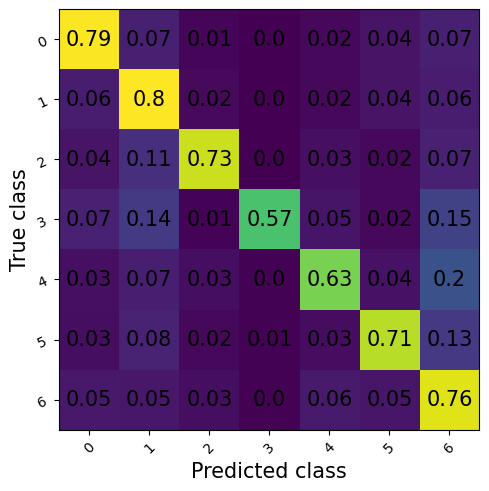

In [36]:
_ = report.get_confusion_matrix('baseline_49', plot = True)

In [37]:
table = report.get_performance_table(metrics = ['accuracy','f1_macro','f1_micro','f1_weighted'])
report_df = pd.DataFrame(table.values())
report_df = report_df.map(lambda x: x.item() if type(x) == torch.Tensor else x)
report_df

AttributeError: 'DataFrame' object has no attribute 'map'

In [57]:
# ALL IS WORKING FINE
report.get_trigger_effect('baseline_666')
report.get_confusion_matrix('baseline_666', plot = False)
report.get_confusion_matrix('baseline_666_t', plot = False)
report.get_precision_recall('baseline_666', plot = False)
report.get_precision_recall('baseline_666_t', plot = False)
report.get_emotions_table()
report.get_misclassified('baseline_666')
report.get_misclassified('baseline_666_t')
report.get_performance_table()
report.get_trigger_table()
report.get_utterance_ranking('baseline_666')
report.get_utterance_ranking('baseline_666_t')


,accuracy,dialogue_len
episode,,
utterance_2863,0.200000,10.0
utterance_2848,0.333333,15.0
utterance_3191,0.333333,3.0
utterance_1443,0.400000,5.0
utterance_1682,0.600000,5.0
utterance_3791,0.600000,5.0
utterance_2199,0.666667,6.0
utterance_1696,0.666667,3.0
utterance_1919,0.666667,3.0


In [39]:
#Some functions return dict or list of dict. check usage in error_analysis.ipynb If you want dataframes visualization, you can do something like this
table = report.get_emotions_table()
print(table)
table_df = pd.DataFrame(table.values())
table_df = table_df.map(lambda x: x.item() if type(x) == torch.Tensor else x)
table_df

{'baseline_666': {'name': 'baseline_666', '0_acc': tensor(0.), '1_acc': tensor(1.), '2_acc': tensor(0.), '3_acc': tensor(0.), '4_acc': tensor(0.), '5_acc': tensor(0.), '6_acc': tensor(0.), '0_f1': tensor(0.), '1_f1': tensor(0.6422), '2_f1': tensor(0.), '3_f1': tensor(0.), '4_f1': tensor(0.), '5_f1': tensor(0.), '6_f1': tensor(0.)}, 'support': {'1_acc': 149, '1_f1': 149, '4_acc': 45, '4_f1': 45, '3_acc': 36, '3_f1': 36, '6_acc': 34, '6_f1': 34, '2_acc': 29, '2_f1': 29, '5_acc': 11, '5_f1': 11, '0_acc': 11, '0_f1': 11, 'name': 'support'}}


,name,0_acc,1_acc,2_acc,3_acc,4_acc,5_acc,6_acc,0_f1,1_f1,2_f1,3_f1,4_f1,5_f1,6_f1
0,baseline_666,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.642241,0.0,0.0,0.0,0.0,0.0
1,support,11.0,149.0,29.0,36.0,45.0,11.0,34.0,11.0,149.000000,29.0,36.0,45.0,11.0,34.0


In [58]:
#TABLE FOR TRIGGER ANALYSIS
table = report.get_trigger_table()
values = [np.array([np.array([v for v in scores.values()]).flatten() for scores in model.values()]).flatten().tolist() for model in table.values()]
columns = next(iter(table.values())).keys()
sub_columns = next(iter(next(iter(table.values())).values())).keys()
indexes = table.keys()
report_df = pd.DataFrame(values, columns = pd.MultiIndex.from_product([tuple(columns), tuple(sub_columns)]), index=indexes)
report_df

emotion_accuracy         support      
                    correct_t bad_t correct_t bad_t
baseline_666              0.0  0.42       0.0  60.0